# 0. DOWNLOAD FUNCTIONS

In [1]:
import os
import sys
import math
import random
import pickle
import warnings
import matplotlib.dates as mdates

from datetime import datetime, timedelta
from bisect import bisect_left
from itertools import combinations
from math import sqrt

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.tseries.offsets import MonthEnd
from matplotlib.patches import Rectangle

from scipy import stats
from scipy.stats import (norm, skew, kurtosis, pearsonr, spearmanr, kendalltau)
from scipy.optimize import curve_fit

from sklearn.metrics import mean_squared_error

import pysal
from numpy.random import Generator, PCG64
from functools import partial


file = "C:/Users/jarra/Desktop/RA ASSISTANT/FINALISED/"

import sys
sys.path.append(file)

import nbimporter
import FUNCTION_LIST as ChatJR # This will import all top-level functions/definitions from the notebook


In [2]:
import inspect

# List all functions defined in the imported notebook
functions_list = [name for name, obj in inspect.getmembers(ChatJR) if inspect.isfunction(obj)]
functions_list

['Converters',
 'Correct_Pres',
 'Correct_Pres_1_col_Only',
 'Correct_Temp',
 'Document',
 'Linear_Regression_Equations',
 'OxmlElement',
 'Perth_Combination',
 'Reduce_to_MSLP_V2_2',
 'SD_Y_WMO_GL',
 'STORM_MSLP_ONLY',
 'STORM_V2',
 'Storm_Finder_AP_2009',
 'Storm_Finder_With_Rain',
 'TO_MSLP',
 'TO_SP',
 'UQC_pres_formats',
 'WMO_Guide_Months',
 'WMO_Guide_Yearly',
 'c_to_f',
 'calculate_gravity',
 'corr_sig',
 'curve_fit',
 'f_to_c',
 'filter_dataframe_by_months',
 'get_ipython',
 'kendalltau',
 'kurtosis',
 'linear_regression_polyfit',
 'mean_squared_error',
 'pearsonr',
 'qm_transfer',
 'qn',
 'rh_fmt_row_day_mean',
 'rh_fmt_row_month_mean_all',
 'rh_fmt_row_month_mean_via_WMO_Guide',
 'rolling_cross_correlate',
 'running_correlation_with_p',
 'save_to_word',
 'skew',
 'spearmanr',
 'ymd_column']

# 1. WRITE AS READ TO MSLP FUNCTION
Since I have now have created the function to go from AS READ to MSLP, I will use what I have an state the assumptions to ensure we have thought about everything to do with the pressure adjustment from As Read to MSLP. This code has been be pushed through its paces and thoroughly thought about over. I also managed to generate a code that replicates the MSLP stated in the journals to which is amazing. From the metadata jounrals, we now know that the as read to adjust gravity and temperature IS NOT THE MSLP and is likely the actual pressure at that height. Therefore from perevious versions of this code we find that the pressure was lower then the pressure presented in the journals. Once applying an extra function that adjusts the pressure by the temperature and height, we get the MLSP which is then higher then the observed journal pressure recordings which makes sense. We expect as the height increases, the pressure decreases.

So from there I have generated a function that takes into account all pressure readings and recording and spits out the MSLP. We know that the impact of different barometers alters the pressure by around 0.5mb, therefore it is not super signficiant and is a useful to know. What actually imapcts the pressure is the change in latitiude which can throw off the pressure by 1 or 2mb. Therefore it is imperitive to understand the latitude coordinates before finalising the pressure, height also plays a significnat factor when going from raw to MSLP, a 60m height change changes the MSLP by around 7 to 8 hPa so a significant difference

# 2. DOWNLOAD TRANSCRIBED DATA
Now to get the data into MSLP format I need to download the data, in a similar fashion as the discussion in the txt file, I will refer to them as numbers and get the pressrure from Transcibed to MSLP

## 2.1 SWAN RIVER
(Note some dates are duplicated in this record, but one version of the duplicated values is NaN)

In [3]:
'''Pressure'''
SWR_Pres_Trans = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\SWAN_RIVER_PRESSURE_TRANSCRIBED_SUBDAILY_1830-1875.csv",
                                index_col=0, parse_dates=True, header=None,names=['Date','Pressure (inHg)'])
SWR_Pres_Trans.index= pd.to_datetime(SWR_Pres_Trans.index,format='mixed',dayfirst = True)

'''Temperature'''
SWR_Temp_Trans = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\SWAN_RIVER_TEMPERATURE_TRANSCRIBED_SUBDAILY_1830-1875.csv")
SWR_Temp_Trans['Date']= pd.to_datetime(SWR_Temp_Trans['date'],dayfirst = True,format='mixed')
SWR_Temp_Trans = SWR_Temp_Trans[['Date','temp']]
SWR_Temp_Trans.set_index('Date',inplace = True)

SWR_Pres_Trans[SWR_Pres_Trans.index.duplicated(keep=False)].dropna()# keep=False keeps all duplicates

X = SWR_Temp_Trans[SWR_Temp_Trans.index.duplicated(keep=False)].dropna()  # keep=False keeps all duplicates
X[X.index.duplicated(keep=False)].dropna()  # keep=False keeps all duplicates

#Lets remove the duplicates of the Swan River record
#Firstly drop all nans - this will remove the dates that are duplicated with nans
SWR_Pres_Trans = SWR_Pres_Trans.dropna()

#Now lets remove duplicates times and keep the first
SWR_Pres_Trans = SWR_Pres_Trans.reset_index().drop_duplicates(subset=['Date'], keep='first').set_index('Date')

#Combine the data and split so we have the same length of data
combined_df = pd.merge(SWR_Pres_Trans, SWR_Temp_Trans, left_index=True, right_index=True, how='inner')
SWR_Temp_Trans = combined_df[['temp']]
SWR_Pres_Trans = combined_df[['Pressure (inHg)']]

#Check pressure SWR_Pres_Trans to show that it is one singular dataset
SWR_Pres_Trans[SWR_Pres_Trans.index.duplicated(keep=False)] # keep=False keeps all duplicates


,Pressure (inHg)
Date,


In [4]:
SWR_Pres_Trans.index.hour.unique().sort_values()


Index([0, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22], dtype='int32', name='Date')

## 2.2 PERTH GARDENS

In [5]:
#Pressure
PG_Pres_Trans = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_GARDENS_PRESSURE_TRANSCRIBED_SUBDAILY_1880_1900.csv",
                                index_col=0, parse_dates=True, header=None,names=['Date','Pressure (hPa)'])
PG_Pres_Trans.index= pd.to_datetime(PG_Pres_Trans.index,dayfirst = True,format='mixed')
#Temperature
PG_Temp_Trans = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_GARDENS_TEMPERATURE_TRANSCRIBED_SUBDAILY_1880_1900.csv")
PG_Temp_Trans.set_index('Date',inplace = True)
PG_Temp_Trans =PG_Temp_Trans[['degF']]
PG_Temp_Trans.index= pd.to_datetime(PG_Temp_Trans.index,dayfirst = True,format='mixed')

#Check duplicates
PG_Pres_Trans[PG_Pres_Trans.index.duplicated(keep=False)].dropna()# keep=False keeps all duplicates

PG_Temp_Trans[PG_Temp_Trans.index.duplicated(keep=False)].dropna()# keep=False keeps all duplicates

#Combine the data and split so we have the same length of data
combined_df = pd.merge(PG_Pres_Trans, PG_Temp_Trans, left_index=True, right_index=True, how='inner')
PG_Temp_Trans = combined_df[['degF']]
PG_Pres_Trans = combined_df[['Pressure (hPa)']]

### 2.2.1 PERTH GARDENS 1881 JAN MSLP

In [6]:
#Pressure
PG_Pres_Jan = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_GARDENS_PRESSURE_MSLP_SUBDAILY_JAN_1881.csv")
PG_Pres_Jan['Date']= pd.to_datetime(PG_Pres_Jan['Date'],dayfirst = True,format='mixed')

#Remove Duplicates from the data
PG_Pres_Jan = PG_Pres_Jan.drop_duplicates(subset=['Date', 'CORRECTED'], keep='first').set_index('Date')

#Since we just need to correct for gravity do what we usually do
PG_Pres_Jan['CORRECTED'] = PG_Pres_Jan['CORRECTED']*33.86

P_81_MSLP = PG_Pres_Jan[['CORRECTED']]

#Calculate GOH, this is local gravity for the barometer
GO_81,H_81 = ChatJR.calculate_gravity(-31.9531, 14.3,'meters')
round(GO_81,3)

#Reduced to MSLP by fixing up pressure now by the gravity constants
P_81_MSLP = ChatJR.Correct_Pres_1_col_Only(P_81_MSLP,GO_81) 
P_81_MSLP['MSLP'] = P_81_MSLP['Correct_temp_gravity_mslp']

PG_Pres_Jan= P_81_MSLP


FUNCTION_LIST.ipynb:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "metadata": {},
C:\Users\jarra\AppData\Local\Temp\ipykernel_16216\3611889983.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_81_MSLP['MSLP'] = P_81_MSLP['Correct_temp_gravity_mslp']


## 2.3 PERTH OBSERVATORY

In [7]:
#Pressure
PO_Pres_Trans = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_OBSERVATORY_PRESSURE_TRANSCRIBED_SUBDAILY_1897-1908.csv",
                                index_col=0, parse_dates=True, header=None,names=['Date','Pressure (inHg)'])
PO_Pres_Trans = PO_Pres_Trans[1:]
PO_Pres_Trans.index= pd.to_datetime(PO_Pres_Trans.index,dayfirst = True,format='mixed')

#Temperature
PO_Temp_Trans = pd.read_excel(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_OBSERVATORY_TEMPERATURE_TRANSCRIBED_SUBDAILY_1897-1908.xlsx",
                                index_col=0, parse_dates=True, header=None,names=['Date','degF'])
PO_Temp_Trans = PO_Temp_Trans[1:]
PO_Temp_Trans['degF'] = pd.to_numeric(PO_Temp_Trans['degF'], errors='coerce')
PO_Temp_Trans.index= pd.to_datetime(PO_Temp_Trans.index,dayfirst = True,format='mixed')
#Check duplicates
PO_Pres_Trans[PO_Pres_Trans.index.duplicated(keep=False)].dropna()# keep=False keeps all duplicates
PO_Temp_Trans[PO_Temp_Trans.index.duplicated(keep=False)].dropna()# keep=False keeps all duplicates

#Combine the data and split so we have the same length of data
combined_df = pd.merge(PO_Pres_Trans, PO_Temp_Trans, left_index=True, right_index=True, how='inner')
PO_Temp_Trans = combined_df[['degF']]
PO_Temp_Trans.loc[:,'degF'] = pd.to_numeric(PO_Temp_Trans['degF'], errors='coerce')
PO_Pres_Trans = combined_df[['Pressure (inHg)']]
PO_Pres_Trans.loc[:,'Pressure (inHg)'] = pd.to_numeric(PO_Pres_Trans['Pressure (inHg)'], errors='coerce')

## 2.4 PERTH REGIONAL OFFICE

In [8]:
#Pressure
PRO_Pres_Trans = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_REGIONAL_OFFICE_PRESSURE_TRANSCRIBED_SUBDAILY_1907-1944.csv")
PRO_Pres_Trans.set_index('Date',inplace = True)
PRO_Pres_Trans.index= pd.to_datetime(PRO_Pres_Trans.index,dayfirst = True,format='mixed')

#Temperature
PRO_Temp_Trans = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_REGIONAL_OFFICE_TEMPERATURE_TRANSCRIBED_SUBDAILY_1907-1944.csv")
PRO_Temp_Trans.set_index('Date',inplace = True)
PRO_Temp_Trans =PRO_Temp_Trans[['degF']]
PRO_Temp_Trans.index= pd.to_datetime(PRO_Temp_Trans.index,dayfirst = True,format='mixed')

#Check duplicates
PRO_Pres_Trans[PRO_Pres_Trans.index.duplicated(keep=False)].dropna()# keep=False keeps all duplicates
PRO_Temp_Trans[PRO_Temp_Trans.index.duplicated(keep=False)].dropna()# keep=False keeps all duplicates

#Combine the data and split so we have the same length of data
combined_df = pd.merge(PRO_Pres_Trans, PRO_Temp_Trans, left_index=True, right_index=True, how='inner')
PRO_Temp_Trans = combined_df[['degF']]
PRO_Temp_Trans.loc[:,'degF'] = pd.to_numeric(PRO_Temp_Trans['degF'], errors='coerce')
PRO_Pres_Trans = combined_df[['inHg']]
PRO_Pres_Trans.loc[:,'inHg'] = pd.to_numeric(PRO_Pres_Trans['inHg'], errors='coerce')


### 2.4.1 DRY BULB TEMPERATURE

In [9]:
PRO_Temp_DB = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_REGIONAL_OFFICE_TEMPERATURE_DRY_BULB_TRANSCRIBED_SUBDAILY_1907_1944.csv")
PRO_Temp_DB.set_index('Date',inplace = True)
PRO_Temp_DB =PRO_Temp_DB[['degC']]
PRO_Temp_DB.index= pd.to_datetime(PRO_Temp_DB.index,dayfirst = True,format='mixed')

PRO_Temp_DB['degC'] = PRO_Temp_DB.replace(-99.9, np.nan)
PRO_Temp_DB= PRO_Temp_DB[['degC']]

#Combine the data and split so we have the same length of data
combined_df = pd.merge(PRO_Pres_Trans, PRO_Temp_DB, left_index=True, right_index=True, how='inner')
PRO_Temp_DB = combined_df[['degC']]
PRO_Temp_DB.loc[:,'degC'] = pd.to_numeric(PRO_Temp_DB['degC'], errors='coerce')
PRO_Pres_Trans_DB = combined_df[['inHg']]
PRO_Pres_Trans_DB.loc[:,'inHg'] = pd.to_numeric(PRO_Pres_Trans_DB['inHg'], errors='coerce')



### 2.4.2 UPDATING THE DATASET TO 1944-MAR (FINISHED, DONT CHANGE TO CODE)

PRO_44 = pd.read_excel(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_REGIONAL_OFFICE_DATA_TRANSCRIBED_SUBDAILY_1944_JAN_MAR.xlsx")
PRO_44_P = PRO_44[['Date','0900 AS READ','1500 AS READ']]

PRO_44_ATT = PRO_44[['Date','0900 ATT','1500 ATT']]

PRO_44_DBT = PRO_44[['Date','0900 DBT','1500 DBT']]


df = PRO_44_P

#Convert DATE to datetime format
df["Date"] = pd.to_datetime(df["Date"])

df.rename(columns = {'0900 AS READ':'9'},inplace =True)
df.rename(columns = {'1500 AS READ':'15'},inplace =True)

df_9 = df[['Date','9']]
df_15 = df[['Date','15']]


#Create separate datetime columns for 0900 and 1500 readings
df_9["Date"]  = df_9["Date"] + pd.to_timedelta("09:00:00")
df_15["Date"]  = df_15["Date"] + pd.to_timedelta("15:00:00")

df_9.rename(columns = {'9':'inHg'},inplace =True)
df_15.rename(columns = {'15':'inHg'},inplace =True)
df_9 = df_9.set_index('Date')
df_15 = df_15.set_index('Date')
PRO_Pres_Trans = pd.concat([PRO_Pres_Trans,df_9,df_15],axis = 0).sort_index()
PRO_Pres_Trans_DB = pd.concat([PRO_Pres_Trans_DB,df_9,df_15],axis = 0).sort_index()

#########################################

df = PRO_44_ATT

#Convert DATE to datetime format
df["Date"] = pd.to_datetime(df["Date"])

df.rename(columns = {'0900 ATT':'9'},inplace =True)
df.rename(columns = {'1500 ATT':'15'},inplace =True)

df_9 = df[['Date','9']]
df_15 = df[['Date','15']]


#Create separate datetime columns for 0900 and 1500 readings
df_9["Date"]  = df_9["Date"] + pd.to_timedelta("09:00:00")
df_15["Date"]  = df_15["Date"] + pd.to_timedelta("15:00:00")

df_9.rename(columns = {'9':'degF'},inplace =True)
df_15.rename(columns = {'15':'degF'},inplace =True)

df_9 = df_9.set_index('Date')
df_15 = df_15.set_index('Date')
PRO_Temp_Trans = pd.concat([PRO_Temp_Trans,df_9,df_15],axis = 0).sort_index()



#########################################

df = PRO_44_DBT

#Convert DATE to datetime format
df["Date"] = pd.to_datetime(df["Date"])

df.rename(columns = {'0900 DBT':'9'},inplace =True)
df.rename(columns = {'1500 DBT':'15'},inplace =True)

df_9 = df[['Date','9']]
df_15 = df[['Date','15']]


#Create separate datetime columns for 0900 and 1500 readings
df_9["Date"]  = df_9["Date"] + pd.to_timedelta("09:00:00")
df_15["Date"]  = df_15["Date"] + pd.to_timedelta("15:00:00")

df_9.rename(columns = {'9':'degF'},inplace =True)
df_15.rename(columns = {'15':'degF'},inplace =True)
df_9 = df_9.set_index('Date')
df_15 = df_15.set_index('Date')
PRO_Temp_DB = pd.concat([PRO_Temp_DB,df_9,df_15],axis = 0).sort_index()

#SAVE THESE
PRO_Pres_Trans.to_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_REGIONAL_OFFICE_PRESSURE_TRANSCRIBED_SUBDAILY_1907-1944.csv")

PRO_Temp_Trans.to_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_REGIONAL_OFFICE_TEMPERATURE_TRANSCRIBED_SUBDAILY_1907-1944.csv")

PRO_Temp_DB.to_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_REGIONAL_OFFICE_DRYBULBTEMP_TRANSCRIBED_SUBDAILY_1907-1944.csv")


## 2.5 PERTH GARDENS MONTHLY

In [10]:
PGm_Pres_Trans = pd.read_excel(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_GARDENS_PRESSURE_TRANSCRIBED_MONTHLY_1876-1899.xlsx")

df_long = pd.melt(PGm_Pres_Trans, id_vars=["Year"], var_name="Month", value_name="inHg")

# Convert month names to numbers
df_long["Month"] = pd.to_datetime(df_long["Month"], format="%b").dt.month

# Create a datetime column
df_long["Date"] = pd.to_datetime(df_long[["Year", "Month"]].assign(Day=1))

# Set the datetime column as the index
df_long = df_long.set_index("Date").sort_index()

# Final DataFrame with "Value" column
PGm_Pres_Trans = df_long[["inHg"]]
# Find duplicate dates
duplicates_pressure = PGm_Pres_Trans.reset_index()[PGm_Pres_Trans.reset_index().duplicated(subset='Date', keep=False)]


## 2.6 TRANSCRIBED MONTHLY PLOTS

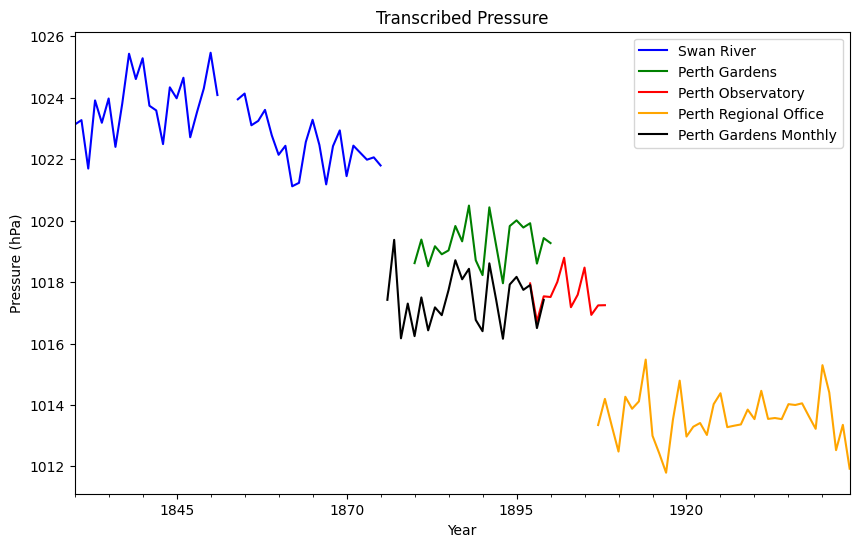

In [11]:
#lets plot these
import matplotlib.pyplot as plt

# Assuming Monthly_Perth_Parallel and PRO_E_S_P are pandas Series with datetime index

# Resample and plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed
(SWR_Pres_Trans*33.86).resample('D').mean().resample('MS').mean().resample('YS').mean().plot(ax=ax, color='blue')
(PG_Pres_Trans).resample('D').mean().resample('MS').mean().resample('YS').mean().plot(ax=ax, color='green')
(PO_Pres_Trans*33.86).resample('D').mean().resample('MS').mean().resample('YS').mean().plot(ax=ax, color='red')
(PRO_Pres_Trans*33.86).resample('D').mean().resample('MS').mean().resample('YS').mean().plot(ax=ax, color='orange')
(PGm_Pres_Trans*33.86).resample('YS').mean().plot(ax=ax, color='black')

# Customize the plot
plt.title('Transcribed Pressure')
plt.xlabel('Year')
plt.ylabel('Pressure (hPa)')
plt.legend(['Swan River','Perth Gardens','Perth Observatory','Perth Regional Office','Perth Gardens Monthly'])


fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\Transcribed_Pressure.png", dpi=300, bbox_inches='tight')


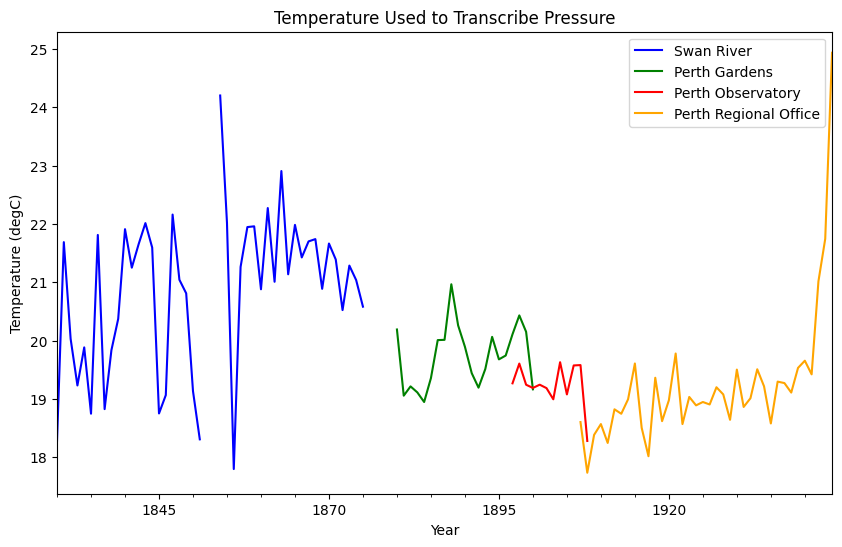

In [12]:
# Resample and plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed
(SWR_Temp_Trans).resample('YE').mean().plot(ax=ax, color='blue')
((PG_Temp_Trans-32)*(5/9)).resample('YE').mean().plot(ax=ax, color='green')
((PO_Temp_Trans-32)*(5/9)).resample('YE').mean().plot(ax=ax, color='red')
((PRO_Temp_Trans-32)*(5/9)).resample('YE').mean().plot(ax=ax, color='orange')

# Customize the plot
plt.title('Temperature Used to Transcribe Pressure')
plt.xlabel('Year')
plt.ylabel('Temperature (degC)')
plt.legend(['Swan River','Perth Gardens','Perth Observatory','Perth Regional Office'])

fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\Transcribed_Temperature.png", dpi=300, bbox_inches='tight')


# 3.SHOWCASING MSLP FUNCTION IF UNDER DIFFERENT CONDITIONS, LIKE COOLER OR HOTTER TEMPERATURE, DIFFERENT BAROMETERS ETC (PERTH REGIONAL OFFICE)

We aim to showcase all the different options of how temperature, barometer type and height influence the overall pressure. This will be done based on:

Temperature:
Normal
+5C
-5C

Height:
Normal
+10m
-10m

Barometer
Unknown/Fortin
Kew-Pattern Cistern
Feuss Cistern

Latitude:
Normal
+2deg
-2deg




In [13]:
TESTER_P = PRO_Pres_Trans.loc[:'1941-12-31']
TESTER_T = PRO_Temp_Trans.loc[:'1941-12-31']

Normal = ChatJR.Reduce_to_MSLP_V2_2(Pressure_Data = TESTER_P,
                    Temperature_Data = TESTER_T, 
                    Barometer_Type = 'Fortin', 
                    Pressure_Unit = 'inHg', 
                    Temperature_Unit = 'degF', 
                    latitude = -31.953, 
                    elevation_feet = 60, 
                    elevation_type = 'metres')
Normal = Normal[['MSLP']]

#### 3.1 Temperature first

In [14]:
TESTER_T_5HIGHER = (((TESTER_T-32)*(5/9)) + 5).round(1)
TESTER_T_5LOWER = (((TESTER_T-32)*(5/9)) - 5).round(1)

TEMP_5HIGHER = ChatJR.Reduce_to_MSLP_V2_2(Pressure_Data = TESTER_P,
                    Temperature_Data = TESTER_T_5HIGHER, 
                    Barometer_Type = 'Fortin', 
                    Pressure_Unit = 'inHg', 
                    Temperature_Unit = 'degC', 
                    latitude = -31.953, 
                    elevation_feet = 60, 
                    elevation_type = 'metres')
TEMP_5HIGHER = TEMP_5HIGHER[['MSLP']]

TEMP_5LOWER = ChatJR.Reduce_to_MSLP_V2_2(Pressure_Data = TESTER_P,
                    Temperature_Data = TESTER_T_5LOWER, 
                    Barometer_Type = 'Fortin', 
                    Pressure_Unit = 'inHg', 
                    Temperature_Unit = 'degC', 
                    latitude = -31.953, 
                    elevation_feet = 60, 
                    elevation_type = 'metres')
TEMP_5LOWER = TEMP_5LOWER[['MSLP']]

TEMP_DB = ChatJR.Reduce_to_MSLP_V2_2(Pressure_Data = PRO_Pres_Trans_DB,
                    Temperature_Data = PRO_Temp_DB, 
                    Barometer_Type = 'Fortin', 
                    Pressure_Unit = 'inHg', 
                    Temperature_Unit = 'degC', 
                    latitude = -31.953, 
                    elevation_feet = 60, 
                    elevation_type = 'metres')
TEMP_DB = TEMP_DB[['MSLP']]

#### 3.2 HEIGHT

In [15]:
HEIGHT_10_HIGHER =  ChatJR.Reduce_to_MSLP_V2_2(Pressure_Data = TESTER_P,
                    Temperature_Data = TESTER_T, 
                    Barometer_Type = 'Fortin', 
                    Pressure_Unit = 'inHg', 
                    Temperature_Unit = 'degF', 
                    latitude = -31.953, 
                    elevation_feet = 70, 
                    elevation_type = 'metres')
HEIGHT_10_HIGHER = HEIGHT_10_HIGHER[['MSLP']]

HEIGHT_10_LOWER = ChatJR.Reduce_to_MSLP_V2_2(Pressure_Data = TESTER_P,
                    Temperature_Data = TESTER_T, 
                    Barometer_Type = 'Fortin', 
                    Pressure_Unit = 'inHg', 
                    Temperature_Unit = 'degF', 
                    latitude = -31.953, 
                    elevation_feet = 50, 
                    elevation_type = 'metres')
HEIGHT_10_LOWER = HEIGHT_10_LOWER[['MSLP']]

#### 3.3 BAROMETER

In [16]:
KEW_PATTERN = ChatJR.Reduce_to_MSLP_V2_2(Pressure_Data = TESTER_P,
                    Temperature_Data = TESTER_T, 
                    Barometer_Type = 'Kew', 
                    Pressure_Unit = 'inHg', 
                    Temperature_Unit = 'degF', 
                    latitude = -31.953, 
                    elevation_feet = 60, 
                    elevation_type = 'metres')
KEW_PATTERN = KEW_PATTERN[['MSLP']]

FUESS = ChatJR.Reduce_to_MSLP_V2_2(Pressure_Data = TESTER_P,
                    Temperature_Data = TESTER_T, 
                    Barometer_Type = 'Fuess', 
                    Pressure_Unit = 'inHg', 
                    Temperature_Unit = 'degF', 
                    latitude = -31.953, 
                    elevation_feet = 60, 
                    elevation_type = 'metres')
FUESS = FUESS[['MSLP']]

#### 3.4 Latitude

In [17]:
LAT_2_NEG = ChatJR.Reduce_to_MSLP_V2_2(Pressure_Data = TESTER_P,
                    Temperature_Data = TESTER_T, 
                    Barometer_Type = 'Fortin', 
                    Pressure_Unit = 'inHg', 
                    Temperature_Unit = 'degF', 
                    latitude = -33.953, 
                    elevation_feet = 60, 
                    elevation_type = 'metres')
LAT_2_NEG = LAT_2_NEG[['MSLP']]

In [18]:
LAT_2_POS = ChatJR.Reduce_to_MSLP_V2_2(Pressure_Data = TESTER_P,
                    Temperature_Data = TESTER_T, 
                    Barometer_Type = 'Fortin', 
                    Pressure_Unit = 'inHg', 
                    Temperature_Unit = 'degF', 
                    latitude = -29.953, 
                    elevation_feet = 60, 
                    elevation_type = 'metres')
LAT_2_POS = LAT_2_POS[['MSLP']]

#### 3.5 PLOT AS BOX PLOTS FOR EACH MONTH

In [19]:
Normal.rename(columns = {'MSLP':'Original + Fortin + Attached Thermometer'},inplace= True)
TEMP_DB.rename(columns = {'MSLP':'Dry Bulb Temperature'},inplace= True)
TEMP_5HIGHER.rename(columns = {'MSLP':'Temperature: 5°C Higher'},inplace= True)
TEMP_5LOWER.rename(columns = {'MSLP':'Temperature: 5°C Lower'},inplace= True)
HEIGHT_10_HIGHER.rename(columns = {'MSLP':'Height: 10m Higher'},inplace= True)
HEIGHT_10_LOWER.rename(columns = {'MSLP':'Height: 10m Lower'},inplace= True)
KEW_PATTERN.rename(columns = {'MSLP':'Kew-Pattern Cistern Barometer'},inplace= True)
FUESS.rename(columns = {'MSLP':'Fuess Cistern Barometer'},inplace= True)
LAT_2_NEG.rename(columns = {'MSLP':'Latitude: 2° More South'},inplace= True)
LAT_2_POS.rename(columns = {'MSLP':'Latitude 2° More North'},inplace= True)

DIFFERENCES_MSLP = pd.concat([Normal, TEMP_DB,TEMP_5HIGHER,TEMP_5LOWER,HEIGHT_10_HIGHER,HEIGHT_10_LOWER,KEW_PATTERN,FUESS,LAT_2_NEG,LAT_2_POS],axis = 1).dropna()
DIFFERENCES_MSLP

,Original + Fortin + Attached Thermometer,Dry Bulb Temperature,Temperature: 5°C Higher,Temperature: 5°C Lower,Height: 10m Higher,Height: 10m Lower,Kew-Pattern Cistern Barometer,Fuess Cistern Barometer,Latitude: 2° More South,Latitude 2° More North
Date,,,,,,,,,,
1907-01-01 09:00:00,1015.01,1015.30,1014.06,1015.96,1016.18,1013.84,1014.84,1014.89,1015.18,1014.84
1907-01-01 15:00:00,1015.04,1015.45,1014.09,1015.98,1016.21,1013.87,1014.86,1014.92,1015.21,1014.87
1907-01-02 09:00:00,1016.91,1017.15,1015.97,1017.87,1018.09,1015.74,1016.74,1016.80,1017.08,1016.75
1907-01-02 15:00:00,1014.22,1013.68,1013.27,1015.16,1015.38,1013.05,1014.03,1014.09,1014.39,1014.05
1907-01-03 09:00:00,1011.04,1011.24,1010.10,1012.00,1012.21,1009.88,1010.87,1010.93,1011.21,1010.88
...,...,...,...,...,...,...,...,...,...,...
1941-12-30 15:00:00,1007.43,1007.02,1006.48,1008.36,1008.56,1006.29,1007.19,1007.27,1007.59,1007.26
1941-12-30 21:00:00,1008.62,1009.61,1007.69,1009.57,1009.76,1007.49,1008.40,1008.48,1008.79,1008.46
1941-12-31 09:00:00,1012.47,1012.37,1011.52,1013.41,1013.63,1011.31,1012.28,1012.34,1012.64,1012.30


In [20]:
#9am
DIFFERENCES_MSLP_9 = DIFFERENCES_MSLP[DIFFERENCES_MSLP.index.hour == 9].resample('MS').mean().round(1)
DIFFERENCES_MSLP_15 = DIFFERENCES_MSLP[DIFFERENCES_MSLP.index.hour == 15].resample('MS').mean().round(1)
DIFFERENCES_MSLP_21 = DIFFERENCES_MSLP[DIFFERENCES_MSLP.index.hour == 21].resample('MS').mean().round(1)

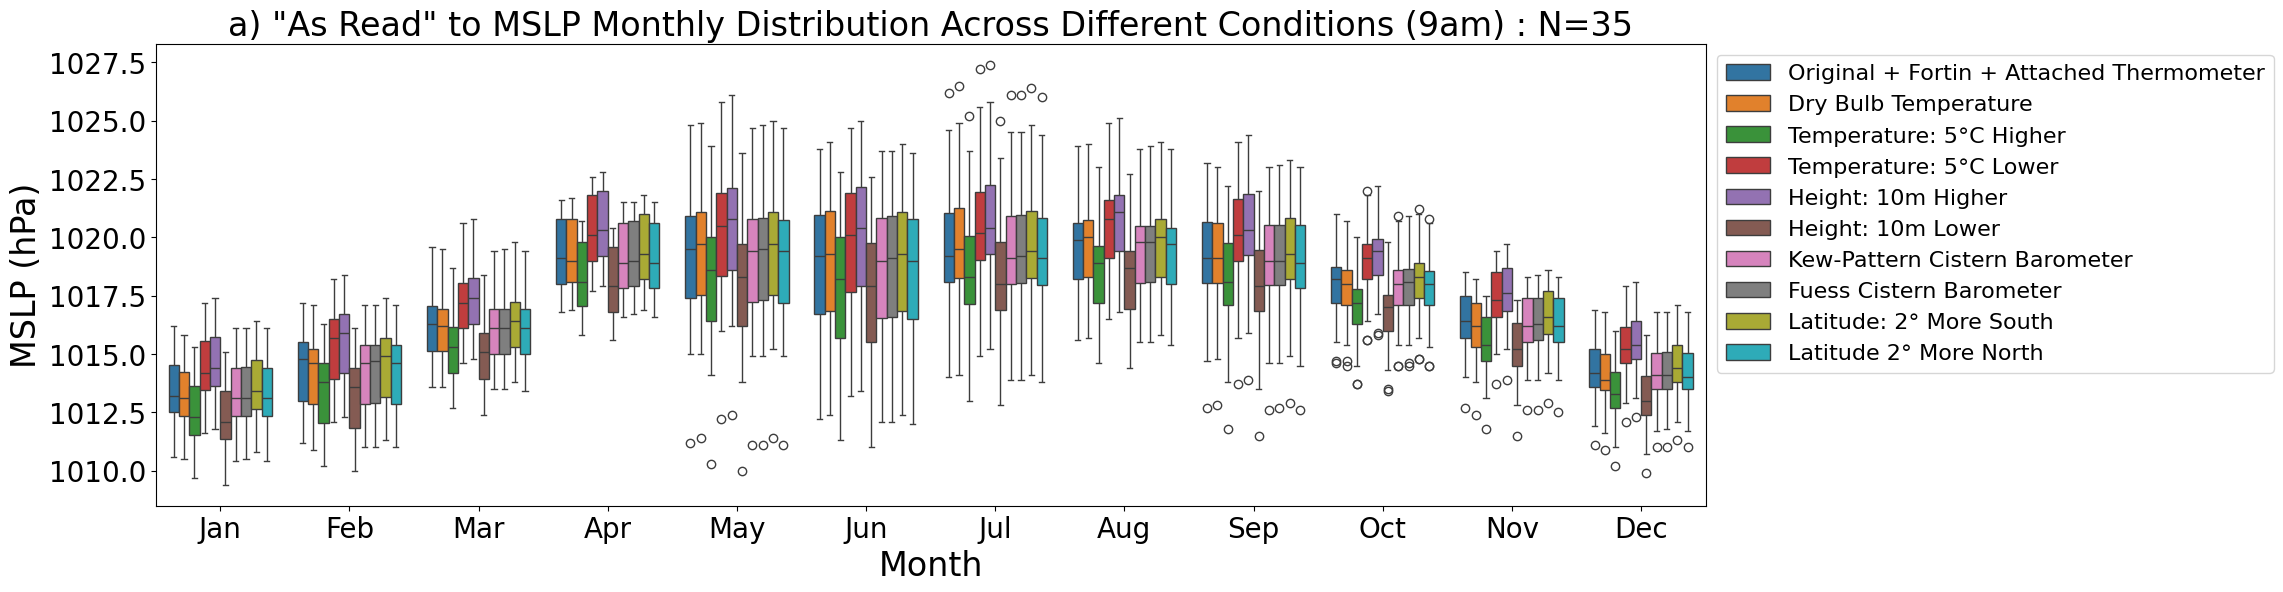

In [21]:
DATA = DIFFERENCES_MSLP_9
# Extract Month and Year
DATA["Year"] = DATA.index.year
DATA["Month"] = DATA.index.month
LENGTH  = len(DATA.resample('YS').mean())


# Melt the dataframe to convert columns into a long format for seaborn
df_melted = DATA.melt(id_vars=["Year", "Month"], var_name="Category", value_name="MSLP")

# Create a grid of box plots, one per month
fig = plt.figure(figsize=(20, 6))
sns.boxplot(x=df_melted["Month"], y=df_melted["MSLP"], hue=df_melted["Category"])

# Formatting
plt.xlabel("Month",fontsize = 24)
plt.ylabel("MSLP (hPa)",fontsize = 24)
plt.title("a) \"As Read\" to MSLP Monthly Distribution Across Different Conditions (9am) : N={}".format(LENGTH),fontsize = 24)
plt.xticks(ticks=range(12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],fontsize = 20)
plt.legend(title="", bbox_to_anchor=(1.0, 1), loc="upper left",fontsize = 16)
plt.yticks(fontsize = 20)

# Show the plot
fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\TO_MSLP_COMPARISONS_9AM.png", dpi=300, bbox_inches='tight')
fig.savefig(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Figure files\Direct From Script\TO_MSLP_COMPARISONS_9AM.png", dpi=300, bbox_inches='tight')


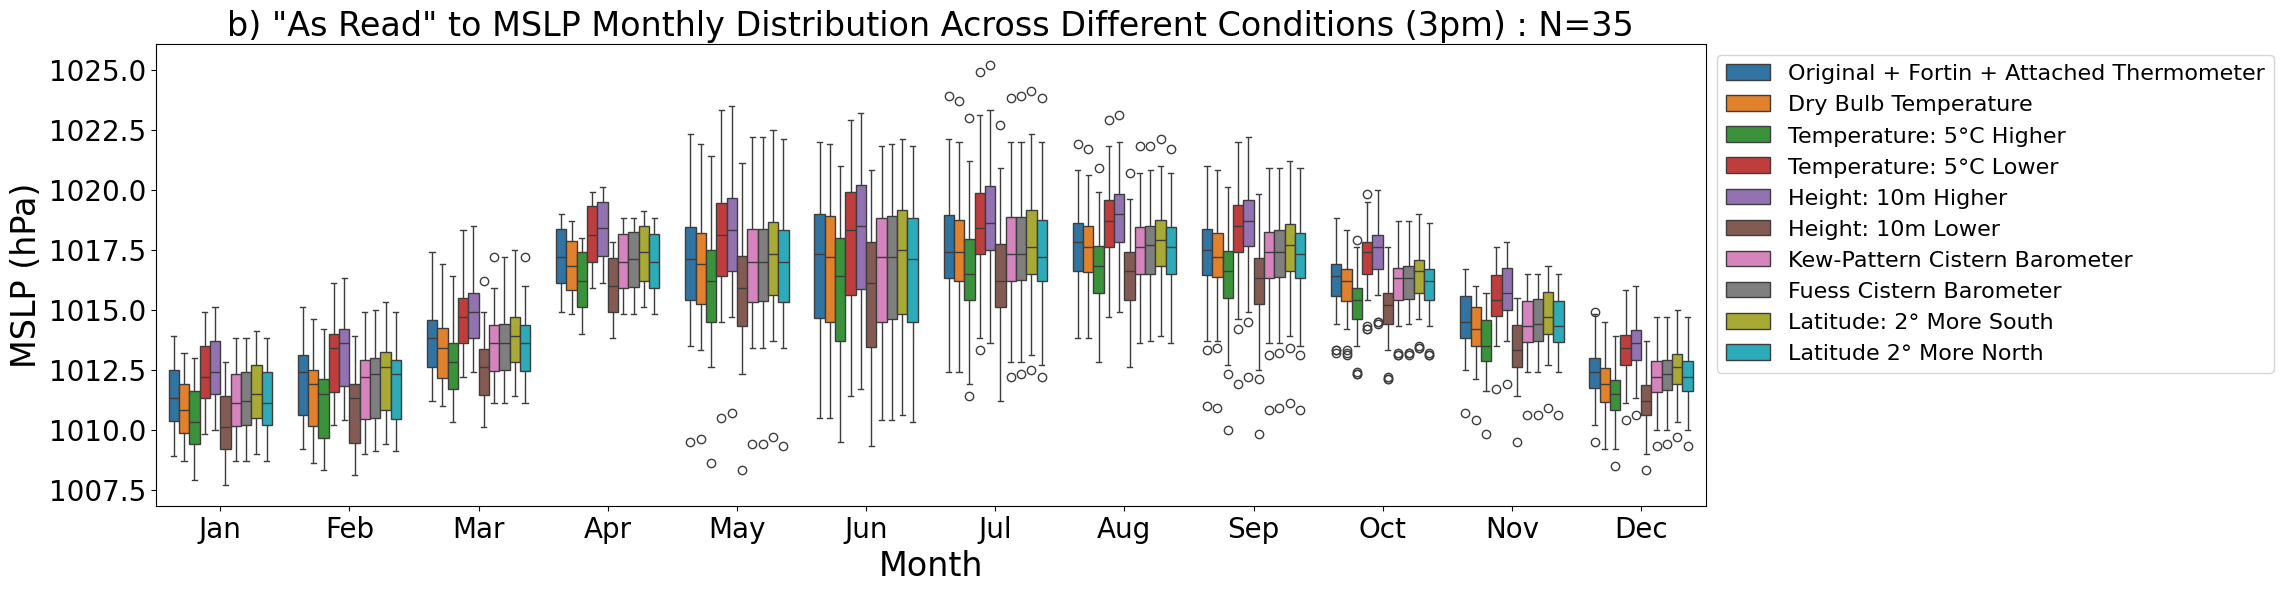

In [22]:
DATA = DIFFERENCES_MSLP_15
# Extract Month and Year
DATA["Year"] = DATA.index.year
DATA["Month"] = DATA.index.month
LENGTH  = len(DATA.resample('YS').mean())


# Melt the dataframe to convert columns into a long format for seaborn
df_melted = DATA.melt(id_vars=["Year", "Month"], var_name="Category", value_name="MSLP")

# Create a grid of box plots, one per month
fig = plt.figure(figsize=(20, 6))
sns.boxplot(x=df_melted["Month"], y=df_melted["MSLP"], hue=df_melted["Category"])

# Formatting
plt.xlabel("Month",fontsize = 24)
plt.ylabel("MSLP (hPa)",fontsize = 24)
plt.title("b) \"As Read\" to MSLP Monthly Distribution Across Different Conditions (3pm) : N={}".format(LENGTH),fontsize = 24)
plt.xticks(ticks=range(12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],fontsize = 20)
plt.legend(title="", bbox_to_anchor=(1.0, 1), loc="upper left",fontsize = 16)
plt.yticks(fontsize = 20)

# Show the plot
fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\TO_MSLP_COMPARISONS_3PM.png", dpi=300, bbox_inches='tight')
fig.savefig(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Figure files\Direct From Script\TO_MSLP_COMPARISONS_3PM.png", dpi=300, bbox_inches='tight')


# 4. APPLY MY TO_MSLP FUNCTION ON THESE DATASETS
Now we need to use the temperature and apply the functions to the MSLP with the best of our knowledge. The only one that may not work well with would be the Swan River

Now interesingly, We know Perth Regional Office is the highest position compared ot the rest of the record and in fact it is the lowest average pressure reading compared to the others. I need to ocnfirm the rest, but I will provide a detailed discussion on those when they come

To correct the dataset, we need to know 3 ideas.

1. what is the location of the Perth Reg Office Station
2. What is the height above sea level
3. What type of barameter does it use?

1908-1941 it was at the Perth Observatory which was what we know as Perth Regional Office/Perth Gardens or in the perth metropoliton area. We know they are at different locations. We can go ahead and do the corrections for:

a) Swan River

b) Perth Gardens

c Perth Observatory

d) Perth Regional Office



## 4.1 SWAN RIVER

Refer to table in manuscrip

In [23]:
SWR_Pres_MSLP = ChatJR.Reduce_to_MSLP_V2_2(Pressure_Data = SWR_Pres_Trans,
                    Temperature_Data = SWR_Temp_Trans, 
                    Barometer_Type = 'Fortin', 
                    Pressure_Unit = 'inHg', 
                    Temperature_Unit = 'degC', 
                    latitude = -31.953, 
                    elevation_feet = 14.3, 
                    elevation_type = 'metres')

### 4.1.1 - Reduce temperature only (For 20CR)

In [24]:
Pressure_Data = SWR_Pres_Trans
Temperature_Data = SWR_Temp_Trans
Barometer_Type = 'Fortin'
Pressure_Unit = 'inHg'
Temperature_Unit = 'degC' 
latitude = -31.953
elevation_feet = 14.3
elevation_type = 'metres'

#Convert up the data so Pressure is in mb and temperature is in degC
PT_Fixed = ChatJR.Converters(Pressure_Data,Temperature_Data,Pressure_Unit,Temperature_Unit)  

#Caculate the Barometer reading freduced to standard temperature but not to standard gravity
SWR_River_Temp_Corrected = ChatJR.Correct_Temp(PT_Fixed[0],PT_Fixed[1],Barometer_Type)  

## 4.2 PERTH GARDENS 

Refer to manuscript table


C:\Users\jarra\AppData\Local\Temp\ipykernel_16216\2462475112.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  PG_Pres_MSLP['MSLP'].dropna().resample('M').mean().plot()


Date
1881-01-01 09:00:00    1016.320000
1881-01-01 12:00:00    1015.370000
1881-01-02 09:00:00    1015.870000
1881-01-02 12:00:00    1013.760000
1881-01-03 09:00:00    1009.440000
1881-01-03 12:00:00    1006.540000
1881-01-04 09:00:00    1009.940000
1881-01-04 12:00:00    1009.010000
1881-01-05 09:00:00    1009.130000
1881-01-05 12:00:00    1007.220000
1881-01-06 09:00:00    1004.140000
1881-01-06 12:00:00    1002.840000
1881-01-07 09:00:00    1007.200000
1881-01-07 12:00:00    1008.120000
1881-01-08 12:00:00    1009.024403
1881-01-09 12:00:00    1011.324097
1881-01-10 12:00:00    1013.488515
1881-01-11 12:00:00    1011.324097
1881-01-12 12:00:00    1006.183605
1881-01-13 12:00:00    1001.719494
1881-01-14 12:00:00    1011.324097
1881-01-15 12:00:00    1014.773638
1881-01-16 12:00:00    1012.879772
1881-01-17 12:00:00    1004.763206
1881-01-18 12:00:00    1011.459373
1881-01-19 12:00:00    1017.242426
1881-01-20 12:00:00    1019.542120
1881-01-21 12:00:00    1018.020264
1881-01-22 12:0

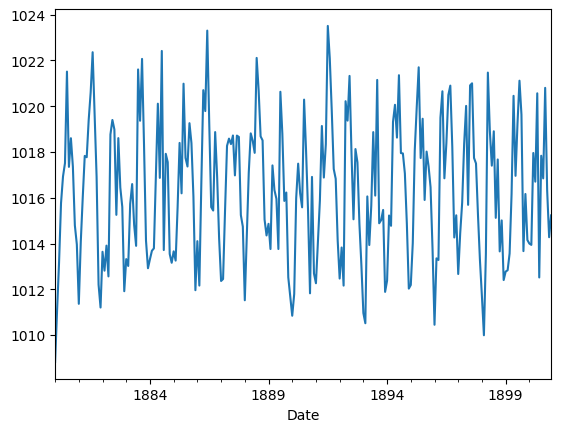

In [25]:
Pre1 = ChatJR.Reduce_to_MSLP_V2_2(Pressure_Data = PG_Pres_Trans.loc[:'1884-12-31'],
                    Temperature_Data = PG_Temp_Trans.loc[:'1884-12-31'],
                    Barometer_Type = 'Kew', 
                    Pressure_Unit = 'hPa', 
                    Temperature_Unit = 'degF', 
                    latitude = -31.9531, 
                    elevation_feet = 47, 
                    elevation_type = 'feet')

Pre2 = ChatJR.Reduce_to_MSLP_V2_2(Pressure_Data = PG_Pres_Trans.loc['1885-01-01':'1887-07-13'],
                    Temperature_Data = PG_Temp_Trans.loc['1885-01-01':'1887-07-13'],
                    Barometer_Type = 'Kew', 
                    Pressure_Unit = 'hPa', 
                    Temperature_Unit = 'degF', 
                    latitude = -31.953, 
                    elevation_feet = 59, 
                    elevation_type = 'feet')
                    
Pos = ChatJR.Reduce_to_MSLP_V2_2(Pressure_Data = PG_Pres_Trans.loc['1887-07-14':],
                    Temperature_Data = PG_Temp_Trans.loc['1887-07-14':], 
                    Barometer_Type = 'Kew', 
                    Pressure_Unit = 'hPa', 
                    Temperature_Unit = 'degF', 
                    latitude = -31.9557, 
                    elevation_feet = 47, 
                    elevation_type = 'feet')
PG_Pres_MSLP = pd.concat([Pre1,Pre2,Pos],axis=0)

#Add PG_Jan to
PG_Pres_MSLP = pd.concat([PG_Pres_MSLP,PG_Pres_Jan],axis=0).sort_index()
PG_Pres_MSLP['MSLP'].dropna().resample('M').mean().plot()

PG_Pres_MSLP.loc['1881']['MSLP'].dropna().head(50)

# 4.2.1 Temp Corrected Only (FOR 20CR)

In [26]:
Pressure_Data = PG_Pres_Trans.loc[:'1884-12-31']
Temperature_Data = PG_Temp_Trans.loc[:'1884-12-31']
Barometer_Type = 'Kew'
Pressure_Unit = 'hPa'
Temperature_Unit = 'degF' 
latitude = -31.9531 
elevation_feet = 47
elevation_type = 'feet'

#Convert up the data so Pressure is in mb and temperature is in degC
PT_Fixed = ChatJR.Converters(Pressure_Data,Temperature_Data,Pressure_Unit,Temperature_Unit)  

#Caculate the Barometer reading freduced to standard temperature but not to standard gravity
Perth_Gardens_80_84_Temp_Corrected = ChatJR.Correct_Temp(PT_Fixed[0],PT_Fixed[1],Barometer_Type)  

In [27]:
Pressure_Data = PG_Pres_Trans.loc['1885-01-01':'1887-07-13']
Temperature_Data = PG_Temp_Trans.loc['1885-01-01':'1887-07-13']
Barometer_Type = 'Kew'
Pressure_Unit = 'hPa' 
Temperature_Unit = 'degF' 
latitude = -31.953
elevation_feet = 59 
elevation_type = 'feet'


#Convert up the data so Pressure is in mb and temperature is in degC
PT_Fixed = ChatJR.Converters(Pressure_Data,Temperature_Data,Pressure_Unit,Temperature_Unit)  

#Caculate the Barometer reading freduced to standard temperature but not to standard gravity
Perth_Gardens_85_87_Temp_Corrected = ChatJR.Correct_Temp(PT_Fixed[0],PT_Fixed[1],Barometer_Type)

In [28]:
Pressure_Data = PG_Pres_Trans.loc['1887-07-14':]
Temperature_Data = PG_Temp_Trans.loc['1887-07-14':]
Barometer_Type = 'Kew' 
Pressure_Unit = 'hPa'
Temperature_Unit = 'degF'
latitude = -31.9557 
elevation_feet = 47
elevation_type = 'feet'


#Convert up the data so Pressure is in mb and temperature is in degC
PT_Fixed = ChatJR.Converters(Pressure_Data,Temperature_Data,Pressure_Unit,Temperature_Unit)  

#Caculate the Barometer reading freduced to standard temperature but not to standard gravity
Perth_Gardens_87_00_Temp_Corrected = ChatJR.Correct_Temp(PT_Fixed[0],PT_Fixed[1],Barometer_Type)

Perth_Gardens_Temp_Corrected = pd.concat([Perth_Gardens_80_84_Temp_Corrected,Perth_Gardens_85_87_Temp_Corrected,Perth_Gardens_87_00_Temp_Corrected],axis=0)


## 4.3 PERTH OBSERVATORY
It is already been reduced to temperature and MSLP, gravity is the final part that needs to be correction in this record

In [29]:
#Lets convert the Pressure and temperature to the respective datasets
P, T= ChatJR.Converters(PO_Pres_Trans,PO_Temp_Trans,'inHg','degF')

P['Correct_temp_mslp'] = P['Raw mb']
#Extract the correct pressure and 
P = P[['Correct_temp_mslp']]

#Calculate GOH, this is local gravity value for the barometer
GOH,H = ChatJR.calculate_gravity(-31.9529, 197,'ft')
GOH = round(GOH,3)
#Fix up the gravity correction from the WMO guidelines

#Reduced to MSLP by fixing up pressure now by the gravity constants
PO_Pres_MSLP = ChatJR.Correct_Pres_1_col_Only(P,GOH) 

PO_Pres_MSLP['MSLP'] = PO_Pres_MSLP['Correct_temp_gravity_mslp']
PO_Pres_MSLP = PO_Pres_MSLP[['MSLP','Correct_temp_mslp']]
PO_Pres_MSLP

,MSLP,Correct_temp_mslp
Date,,
1897-01-01 09:00:00,1014.894156,1016.1386
1897-01-01 15:00:00,NaN,NaN
1897-01-02 09:00:00,1019.256747,1020.50654
1897-01-02 15:00:00,NaN,NaN
1897-01-03 09:00:00,1017.836369,1019.08442
...,...,...
1908-12-30 15:00:00,1011.410847,1012.65102
1908-12-30 21:00:00,1013.135593,1014.37788
1908-12-31 09:00:00,1010.903569,1012.14312


### 4.3.1 For 20CR - convert MSLP to Station pressure using the Gravity ratio

In [30]:
#copy so we dont mix it
PO_Pres_MSLP_FEd = PO_Pres_MSLP['MSLP'].copy()
Perth_Observatory_Temp_Corrected = ChatJR.TO_SP(PO_Pres_MSLP_FEd, T, 60)
Perth_Observatory_Temp_Corrected.name = 'Pressure'
Perth_Observatory_Temp_Corrected= Perth_Observatory_Temp_Corrected.to_frame()

In [31]:
Perth_Observatory_Temp_Corrected


,Pressure
Date,
1897-01-01 09:00:00,1007.975547
1897-01-01 15:00:00,NaN
1897-01-02 09:00:00,1012.096848
1897-01-02 15:00:00,NaN
1897-01-03 09:00:00,1010.833038
...,...
1908-12-30 15:00:00,1004.541355
1908-12-30 21:00:00,1006.093731
1908-12-31 09:00:00,1004.060186


In [32]:
Perth_Observatory_Temp_Corrected

Perth_Observatory_Temp_Corrected = pd.concat([Perth_Observatory_Temp_Corrected],axis=0)
Perth_Observatory_Temp_Corrected

,Pressure
Date,
1897-01-01 09:00:00,1007.975547
1897-01-01 15:00:00,NaN
1897-01-02 09:00:00,1012.096848
1897-01-02 15:00:00,NaN
1897-01-03 09:00:00,1010.833038
...,...
1908-12-30 15:00:00,1004.541355
1908-12-30 21:00:00,1006.093731
1908-12-31 09:00:00,1004.060186


<Axes: xlabel='Date'>

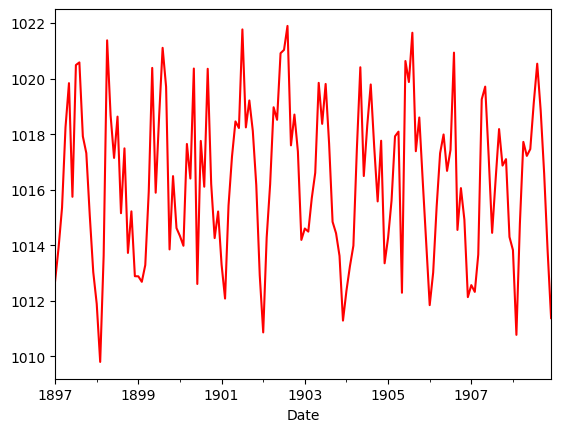

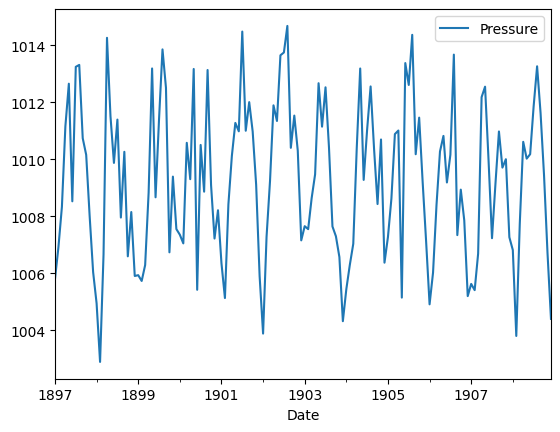

In [33]:
PO_Pres_MSLP['MSLP'].resample('MS').mean().plot(color = 'r')
Perth_Observatory_Temp_Corrected.resample('MS').mean().plot()

## 4.4 PERTH REGIONAL OFFICE
Lat 31 57' to -31.9533 and height is 197 ft for the stand 197ft from the journals -31.9533 from the BOM as mentioned on their metadata website http://www.bom.gov.au/clim_data/cdio/metadata/pdf/siteinfo/IDCJMD0040.009034.SiteInfo.pdf

Also matched bom data at 1942-04, and thats the first instance we know off that it occurs

However, from the journals, we do not know if after april 1942, that it was updated to a Kew Pattern Cistern barometer. But the first instance of the kew pattern barmeter mentioned was in 1942.




Perth Regional Office: 1907-1942/03

Barometer Type = Fortin

Height = 197ft

Location = -31.953

---------------------------------------------------------------------------
Perth Regional Office: 1942/04-1942/08

Barometer Type = Fortin

Height = 210ft

Location = -31.953


---------------------------------------------------------------------------
Perth Regional Office: 1942/09-1944

Barometer Type = Kew Pattern Cistern

Height = 210ft

Location = -31.953


In [34]:
Part1=ChatJR.Reduce_to_MSLP_V2_2(Pressure_Data = PRO_Pres_Trans.loc[:'1942-03-31'],
                    Temperature_Data = PRO_Temp_Trans.loc[:'1942-03-31'], 
                    Barometer_Type = 'Fortin', 
                    Pressure_Unit = 'inHg', 
                    Temperature_Unit = 'degF', 
                    latitude = -31.9533, 
                    elevation_feet = 197, 
                    elevation_type = 'feet')

Part2=ChatJR.Reduce_to_MSLP_V2_2(Pressure_Data = PRO_Pres_Trans.loc['1942-04-01':'1942-08-31'],
                    Temperature_Data = PRO_Temp_Trans.loc['1942-04-01':'1942-08-31'], 
                    Barometer_Type = 'Fortin', 
                    Pressure_Unit = 'inHg', 
                    Temperature_Unit = 'degF', 
                    latitude = -31.9533, 
                    elevation_feet = 210, 
                    elevation_type = 'feet')


Part3=ChatJR.Reduce_to_MSLP_V2_2(Pressure_Data = PRO_Pres_Trans.loc['1942-09-01':],
                    Temperature_Data = PRO_Temp_Trans.loc['1942-09-01':], 
                    Barometer_Type = 'Kew', 
                    Pressure_Unit = 'inHg', 
                    Temperature_Unit = 'degF', 
                    latitude = -31.9533, 
                    elevation_feet = 210, 
                    elevation_type = 'feet')

PRO_Pres_MSLP = pd.concat([Part1,Part2,Part3],axis=0)

# 4.4.1 For 20CR

In [35]:
Pressure_Data = PRO_Pres_Trans.loc[:'1942-03-31']
Temperature_Data = PRO_Temp_Trans.loc[:'1942-03-31']
Barometer_Type = 'Fortin'
Pressure_Unit = 'inHg'
Temperature_Unit = 'degF'
latitude = -31.9533
elevation_feet = 197
elevation_type = 'feet'

#Convert up the data so Pressure is in mb and temperature is in degC
PT_Fixed = ChatJR.Converters(Pressure_Data,Temperature_Data,Pressure_Unit,Temperature_Unit)  

#Caculate the Barometer reading freduced to standard temperature but not to standard gravity
Perth_Regional_07_424_Temp_Corrected = ChatJR.Correct_Temp(PT_Fixed[0],PT_Fixed[1],Barometer_Type) 

In [36]:
Pressure_Data = PRO_Pres_Trans.loc['1942-04-01':'1942-08-31']
Temperature_Data = PRO_Temp_Trans.loc['1942-04-01':'1942-08-31']
Barometer_Type = 'Fortin' 
Pressure_Unit = 'inHg'
Temperature_Unit = 'degF'
latitude = -31.9533
elevation_feet = 210
elevation_type = 'feet'

#Convert up the data so Pressure is in mb and temperature is in degC
PT_Fixed = ChatJR.Converters(Pressure_Data,Temperature_Data,Pressure_Unit,Temperature_Unit)  

#Caculate the Barometer reading freduced to standard temperature but not to standard gravity
Perth_Regional_424_4210_Temp_Corrected = ChatJR.Correct_Temp(PT_Fixed[0],PT_Fixed[1],Barometer_Type) 

In [37]:
Pressure_Data = PRO_Pres_Trans.loc['1942-09-01':]
Temperature_Data = PRO_Temp_Trans.loc['1942-09-01':]
Barometer_Type = 'Kew'
Pressure_Unit = 'inHg'
Temperature_Unit = 'degF'
latitude = -31.9533
elevation_feet = 210
elevation_type = 'feet'

#Convert up the data so Pressure is in mb and temperature is in degC
PT_Fixed = ChatJR.Converters(Pressure_Data,Temperature_Data,Pressure_Unit,Temperature_Unit)  

#Caculate the Barometer reading freduced to standard temperature but not to standard gravity
Perth_Regional_4210_44_Temp_Corrected = ChatJR.Correct_Temp(PT_Fixed[0],PT_Fixed[1],Barometer_Type) 


Perth_Regional_Temp_Corrected = pd.concat([Perth_Regional_07_424_Temp_Corrected,Perth_Regional_424_4210_Temp_Corrected,Perth_Regional_4210_44_Temp_Corrected],axis=0)

# 4.5 PLOT THE CORRECTED MSLPS

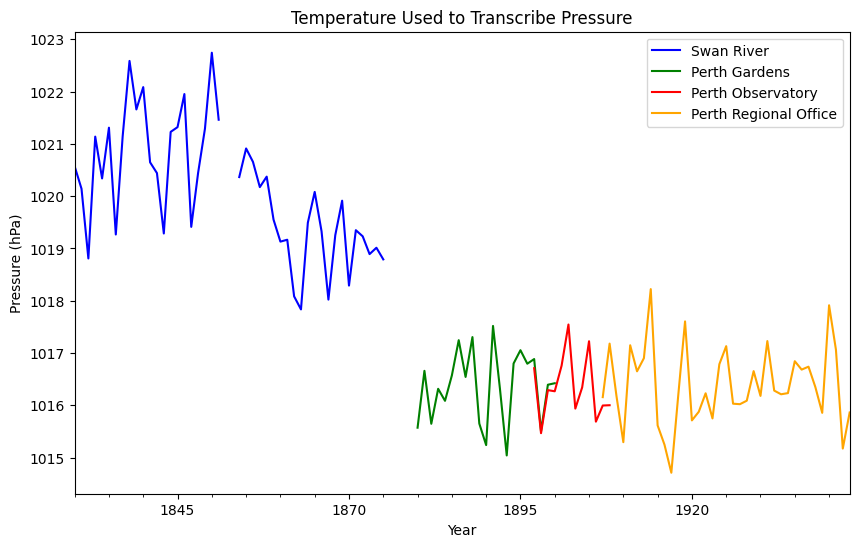

In [38]:

# Resample and plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed
SWR_Pres_MSLP['MSLP'].resample('D').mean().resample('MS').mean().resample('YS').mean().plot(ax=ax, color='blue')
PG_Pres_MSLP['MSLP'].resample('D').mean().resample('MS').mean().resample('YS').mean().plot(ax=ax, color='green')
PO_Pres_MSLP['MSLP'].resample('D').mean().resample('MS').mean().resample('YS').mean().plot(ax=ax, color='red')
PRO_Pres_MSLP['MSLP'].loc[:'1943'].resample('D').mean().resample('MS').mean().resample('YS').mean().plot(ax=ax, color='orange')
# Customize the plot
plt.title('Temperature Used to Transcribe Pressure')
plt.xlabel('Year')
plt.ylabel('Pressure (hPa)')
plt.legend(['Swan River','Perth Gardens','Perth Observatory','Perth Regional Office','Perth Gardens Monthly'])
fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\Corrected_MSLPs.png", dpi=300, bbox_inches='tight')


# 5. ADDITION OF BoMS DATASETS

## 5.1 PERTH REGIONAL OFFICE

In [39]:
#Perth Regional Office
PRO_Pres_BOM = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_REGIONAL_OFFICE_PRESSURE_BOM_SUBDAILY_1942-1992.csv")
PRO_Pres_BOM.columns = ['Date', 'MSLP', 'As Read']
PRO_Pres_BOM['MSLP'] = pd.to_numeric(PRO_Pres_BOM['MSLP'], errors='coerce') /10
PRO_Pres_BOM['As Read'] = pd.to_numeric(PRO_Pres_BOM['As Read'], errors='coerce') /10
PRO_Pres_BOM['Date'] = pd.to_datetime(PRO_Pres_BOM['Date'],format ='mixed',dayfirst = True)
PRO_Pres_BOM.set_index('Date',inplace =True)
PRO_Pres_BOM = PRO_Pres_BOM.mask(PRO_Pres_BOM < 0, np.nan)

## 5.2 PERTH METRO


In [40]:
#Perth Metro
PM_Pres_BoM = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_METRO_PRESSURE_BOM_SUBDAILY_1994-2020.csv")
PM_Pres_BoM.columns = ['Date', 'MSLP', 'As Read']
PM_Pres_BoM['Date'] = pd.to_datetime(PM_Pres_BoM['Date'],format ='mixed',dayfirst = True)
PM_Pres_BoM.set_index('Date',inplace =True)
PM_Pres_BoM['MSLP'] = pd.to_numeric(PM_Pres_BoM['MSLP'], errors='coerce') /10
PM_Pres_BoM['As Read'] = pd.to_numeric(PM_Pres_BoM['As Read'], errors='coerce') /10
PM_Pres_BoM = PM_Pres_BoM.mask(PM_Pres_BoM < 0, np.nan)

####NEWER PERTH METRO AND AIRPORT DATASETS
#Perth Metro
PM_Pres_BoM_2 = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_METRO_PRESSURE_BOM_SUBDAILY_2020-2024.txt",
                     sep=',',)[['Year Month Day Hour Minutes in YYYY','MM','DD','HH24','Mean sea level pressure in hPa']]
PM_Pres_BoM_2.rename(columns = {'Year Month Day Hour Minutes in YYYY':'Year','MM':'Month','DD':'Day','HH24':'Hour','Mean sea level pressure in hPa':'MSLP'},inplace= True)
PM_Pres_BoM_2['Date'] = pd.to_datetime(PM_Pres_BoM_2[['Year', 'Month', 'Day','Hour']],format  ='mixed')
PM_Pres_BoM_2 = PM_Pres_BoM_2[['Date','MSLP']].set_index('Date')
PM_Pres_BoM_2['MSLP'] = pd.to_numeric(PM_Pres_BoM_2['MSLP'], errors='coerce')
PM_Pres_BoM_2 = PM_Pres_BoM_2.mask(PM_Pres_BoM_2 < 0, np.nan)


#PERTH METRO 3

PM_Pres_BoM_2 = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_METRO_PRESSURE_BOM_SUBDAILY_2020-2024.txt",
                     sep=',',)[['Year Month Day Hour Minutes in YYYY','MM','DD','HH24','Mean sea level pressure in hPa']]
PM_Pres_BoM_2.rename(columns = {'Year Month Day Hour Minutes in YYYY':'Year','MM':'Month','DD':'Day','HH24':'Hour','Mean sea level pressure in hPa':'MSLP'},inplace= True)
PM_Pres_BoM_2['Date'] = pd.to_datetime(PM_Pres_BoM_2[['Year', 'Month', 'Day','Hour']],format  ='mixed')
PM_Pres_BoM_2 = PM_Pres_BoM_2[['Date','MSLP']].set_index('Date')
PM_Pres_BoM_2['MSLP'] = pd.to_numeric(PM_Pres_BoM_2['MSLP'], errors='coerce')
PM_Pres_BoM_2 = PM_Pres_BoM_2.mask(PM_Pres_BoM_2 < 0, np.nan)



'''Pressure'''
PM_Pres_BoM_3 = pd.read_fwf(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_METRO_PRESSURE_BOM_SUBDAILY_2023_2024.txt", colspecs=[(1, 7), (7, 20), (27, 33), (35, 41)], 
                   header=None, names=['ID', 'Date', 'MSLP', 'Pressure'])

# Ensure Date column is in the correct format
PM_Pres_BoM_3['Date'] = pd.to_datetime(PM_Pres_BoM_3['Date'], format='%Y%m%d%H%M')
PM_Pres_BoM_3['Pressure'] =PM_Pres_BoM_3['Pressure']/10
PM_Pres_BoM_3['MSLP'] =PM_Pres_BoM_3['MSLP']/10

PM_Pres_BoM_3.set_index('Date',inplace =True)
PM_Pres_BoM_3 = PM_Pres_BoM_3[['MSLP']]






## 5.3 PERTH AIRPORT

In [41]:
#Perth Aiport
PA_Pres_BoM = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_AIRPORT_PRESSURE_BOM_SUBDAILY_1944-2020.csv")
PA_Pres_BoM.columns = ['Date', 'MSLP', 'As Read']
PA_Pres_BoM['Date'] = pd.to_datetime(PA_Pres_BoM['Date'],format ='mixed',dayfirst = True)
PA_Pres_BoM.set_index('Date',inplace =True)
PA_Pres_BoM['MSLP'] = pd.to_numeric(PA_Pres_BoM['MSLP'], errors='coerce') /10
PA_Pres_BoM['As Read'] = pd.to_numeric(PA_Pres_BoM['As Read'], errors='coerce') /10
PA_Pres_BoM = PA_Pres_BoM.mask(PA_Pres_BoM < 0, np.nan)

#Perth Airport
PA_Pres_BoM_2 = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_AIRPORT_PRESSURE_BOM_SUBDAILY_2020-2024.txt",
                     sep=',',)[['Year Month Day Hour Minutes in YYYY','MM','DD','HH24','Mean sea level pressure in hPa']]
PA_Pres_BoM_2.rename(columns = {'Year Month Day Hour Minutes in YYYY':'Year','MM':'Month','DD':'Day','HH24':'Hour','Mean sea level pressure in hPa':'MSLP'},inplace= True)
PA_Pres_BoM_2['Date'] = pd.to_datetime(PA_Pres_BoM_2[['Year', 'Month', 'Day','Hour']],format  ='mixed')
PA_Pres_BoM_2 = PA_Pres_BoM_2[['Date','MSLP']].set_index('Date')
PA_Pres_BoM_2['MSLP'] = pd.to_numeric(PA_Pres_BoM_2['MSLP'], errors='coerce')
PA_Pres_BoM_2 = PA_Pres_BoM_2.mask(PA_Pres_BoM_2 < 0, np.nan)

## 5.4 PLOT ALL TOGETHER

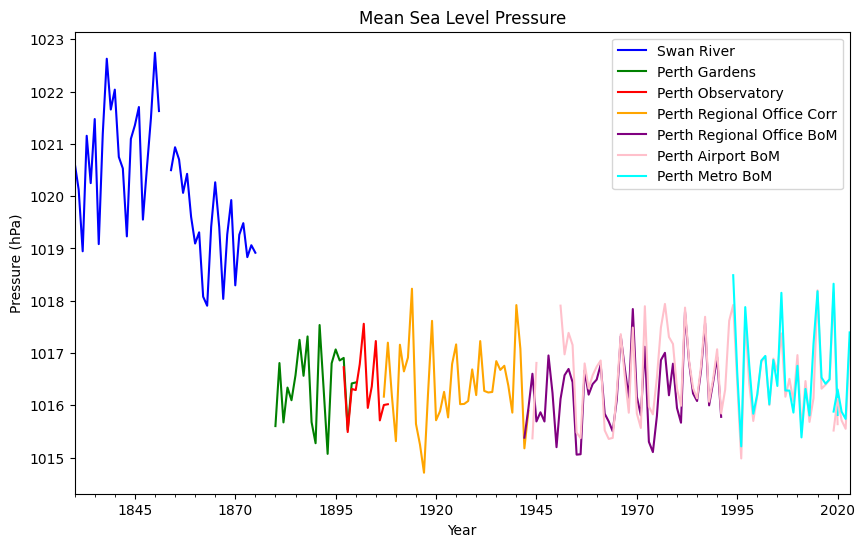

In [42]:
# Resample and plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed
SWR_Pres_MSLP['MSLP'].resample('YS').mean().plot(ax=ax, color='blue')
PG_Pres_MSLP['MSLP'].resample('YS').mean().plot(ax=ax, color='green')
PO_Pres_MSLP['MSLP'].resample('YS').mean().plot(ax=ax, color='red')
PRO_Pres_MSLP.loc[:'1943']['MSLP'].resample('YS').mean().plot(ax=ax, color='orange')
#Monthly_Perth_Parallel['MSLP'].resample('Y').mean().plot(ax=ax, color='black')
PRO_Pres_BOM['MSLP'].loc[:'1991'].resample('YS').mean().plot(ax=ax,color= 'purple')
PA_Pres_BoM['MSLP'].resample('YS').mean().plot(ax=ax,color= 'pink')
PM_Pres_BoM['MSLP'].resample('YS').mean().plot(ax=ax,color= 'cyan')
PA_Pres_BoM_2['MSLP'].loc[:'2023'].resample('YS').mean().plot(ax=ax,color= 'pink')
PM_Pres_BoM_2['MSLP'].loc[:'2023'].resample('YS').mean().plot(ax=ax,color= 'cyan')

# Customize the plot
plt.title('Mean Sea Level Pressure')
plt.xlabel('Year')
plt.ylabel('Pressure (hPa)')
plt.legend(['Swan River','Perth Gardens','Perth Observatory','Perth Regional Office Corr','Perth Regional Office BoM',
           'Perth Airport BoM', 'Perth Metro BoM'])
fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\MSLPs_Ours_BoMs.png", dpi=300, bbox_inches='tight')


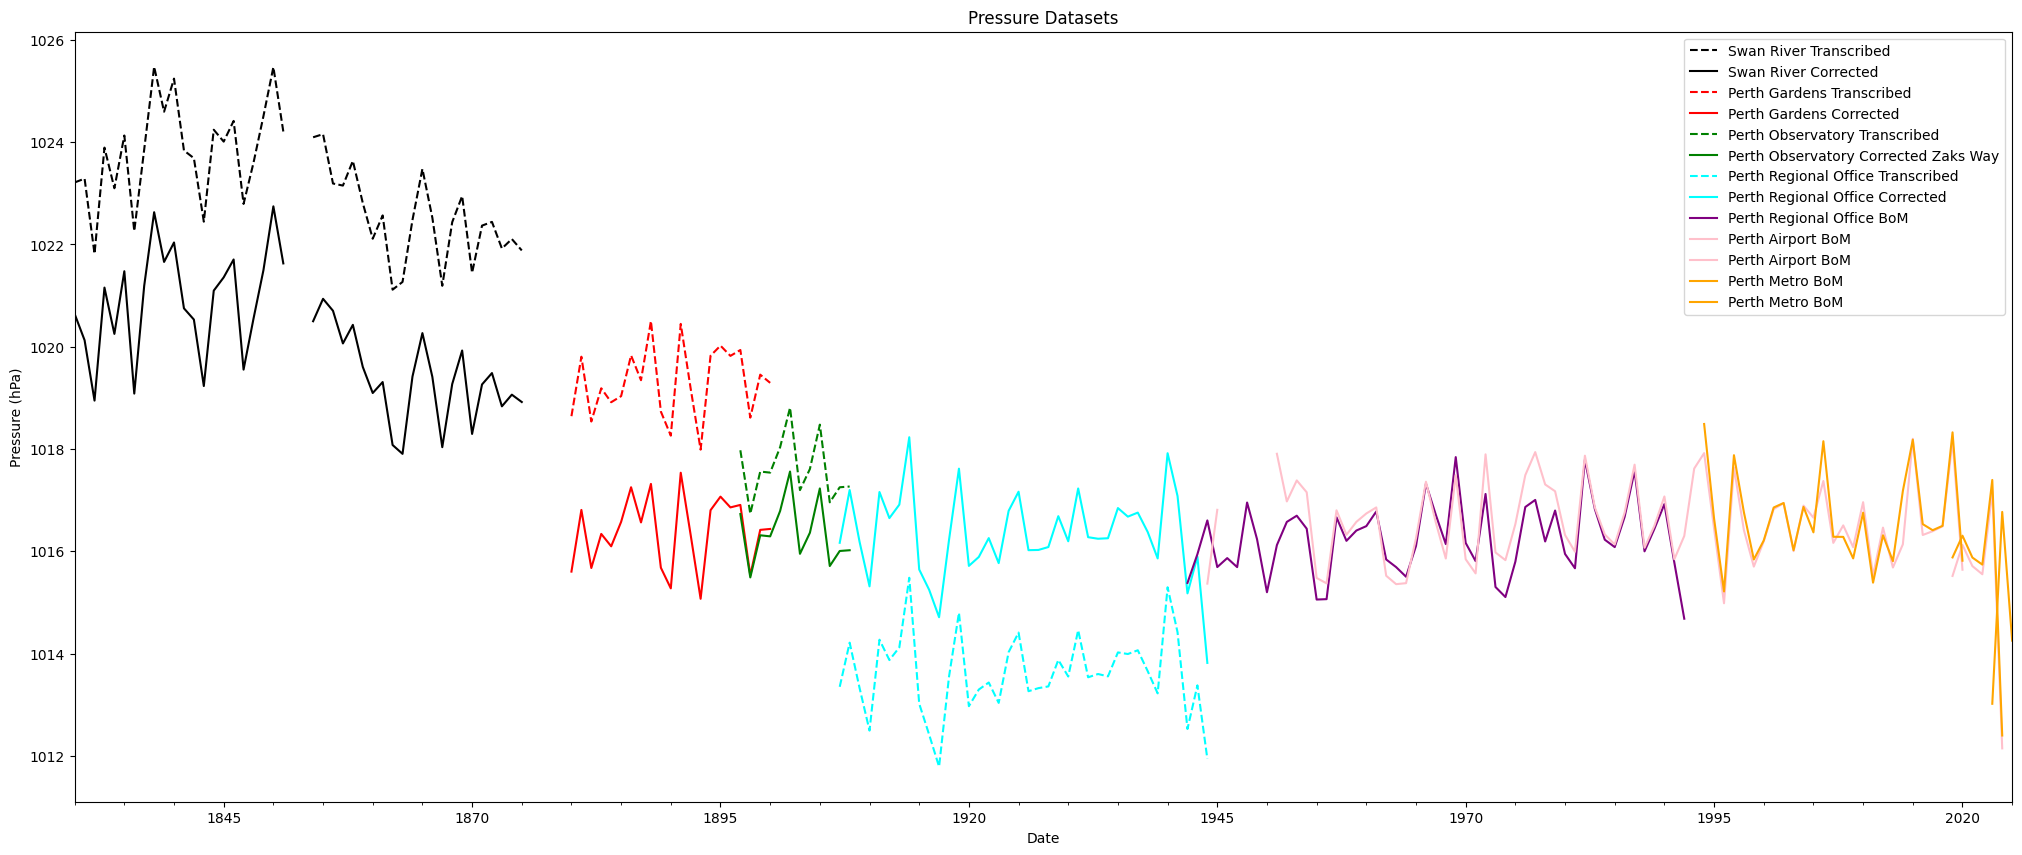

In [43]:
# ORIGINAL ONE
fig, ax = plt.subplots(figsize=(25, 10))  # Adjust the figsize as needed
(SWR_Pres_Trans*33.86).resample('YE').mean().plot(ax=ax,linestyle = '--',color= 'black')
SWR_Pres_MSLP['MSLP'].resample('YE').mean().plot(ax=ax,color= 'black')

PG_Pres_Trans.resample('YE').mean().plot(ax=ax,linestyle = '--',color= 'red')
PG_Pres_MSLP['MSLP'].resample('YE').mean().plot(ax=ax,color= 'red')

(PO_Pres_Trans*33.86).resample('YE').mean().plot(ax=ax,linestyle = '--',color= 'green')
PO_Pres_MSLP['MSLP'].resample('YE').mean().plot(ax=ax,color= 'green')

(PRO_Pres_Trans*33.86).resample('YE').mean().plot(ax=ax,linestyle = '--',color= 'cyan')
PRO_Pres_MSLP['MSLP'].resample('YE').mean().plot(ax=ax,color= 'cyan')

PRO_Pres_BOM['MSLP'].resample('YE').mean().plot(ax=ax,color= 'purple')

PA_Pres_BoM['MSLP'].resample('YE').mean().plot(ax=ax,color= 'pink')
PA_Pres_BoM_2['MSLP'].resample('YE').mean().plot(ax=ax,color= 'pink')

PM_Pres_BoM['MSLP'].resample('YE').mean().plot(ax=ax,color= 'orange')
PM_Pres_BoM_2['MSLP'].resample('YE').mean().plot(ax=ax,color= 'orange')
PM_Pres_BoM_3['MSLP'].resample('YE').mean().plot(ax=ax,color= 'orange')


ax.legend(['Swan River Transcribed','Swan River Corrected',
           'Perth Gardens Transcribed','Perth Gardens Corrected',
           'Perth Observatory Transcribed','Perth Observatory Corrected Zaks Way',
           'Perth Regional Office Transcribed','Perth Regional Office Corrected',
          'Perth Regional Office BoM',
           'Perth Airport BoM','Perth Airport BoM',
           'Perth Metro BoM','Perth Metro BoM'])

ax.set_title('Pressure Datasets')
ax.set_xlabel('Date')
ax.set_ylabel('Pressure (hPa)')

fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\MSLPs_Ours_BoMs_With_As_Read.png", dpi=300, bbox_inches='tight')


# 6. PERTH GARDENS MONHTLY DATASET 

Perth Gardens (ID 009097): 1880-1884

Barometer Type = Cistern

Height = 14m/47ft

Location = -31.95, 115.85

---------------------------------------------------------------------------
Perth Gardens (ID 009097): 1885-1900

Barometer Type = Cistern

Height = 17m

Location = -31.95, 115.85

In [44]:
PGm_Pres_Trans['Correct_temp_mslp'] = PGm_Pres_Trans['inHg']*33.86
P = PGm_Pres_Trans[['Correct_temp_mslp']]


# 1880-1884
P_80_84 = P.loc[:'1884-12-31']

#Calculate GOH, this is local gravity for the barometer
GO_80_84,H_80_84 = ChatJR.calculate_gravity(-31.9531, 14.3,'meters')
round(GO_80_84,3)
#Reduced to MSLP by fixing up pressure now by the gravity constants
P_80_84_MSLP = ChatJR.Correct_Pres_1_col_Only(P_80_84,GO_80_84) 
P_80_84_MSLP['MSLP'] = P_80_84_MSLP['Correct_temp_gravity_mslp']



# 1885-1887-06
P_85_87 = P.loc['1885-01-01':'1887-06-01']

#Calculate GOH, this is local gravity for the barometer
GO_85_87,H_85_87 = ChatJR.calculate_gravity(-31.9531, 18,'meters')
round(GO_85_87,3)

#Reduced to MSLP by fixing up pressure now by the gravity constants
P_85_87_MSLP = ChatJR.Correct_Pres_1_col_Only(P_85_87,GO_85_87) 
P_85_87_MSLP['MSLP'] = P_85_87_MSLP['Correct_temp_gravity_mslp']


# 1885-1900B
P_87_00 = P.loc['1887-07-01':]

#Calculate GOH, this is local gravity for the barometer
GO_87_00,H_87_00 = ChatJR.calculate_gravity(-31.9557, 14.3,'meters')
round(GO_87_00,3)

#Reduced to MSLP by fixing up pressure now by the gravity constants
P_87_00_MSLP = ChatJR.Correct_Pres_1_col_Only(P_87_00,GO_87_00) 
P_87_00_MSLP['MSLP'] = P_87_00_MSLP['Correct_temp_gravity_mslp']

#Add all together
PGm_Pres_MSLP = pd.concat([P_80_84_MSLP,P_85_87_MSLP,P_87_00_MSLP],axis=0)
PGm_Pres_MSLP = PGm_Pres_MSLP[['MSLP','Correct_temp_mslp']]

C:\Users\jarra\AppData\Local\Temp\ipykernel_16216\2703294095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PGm_Pres_Trans['Correct_temp_mslp'] = PGm_Pres_Trans['inHg']*33.86
FUNCTION_LIST.ipynb:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "metadata": {},
C:\Users\jarra\AppData\Local\Temp\ipykernel_16216\2703294095.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

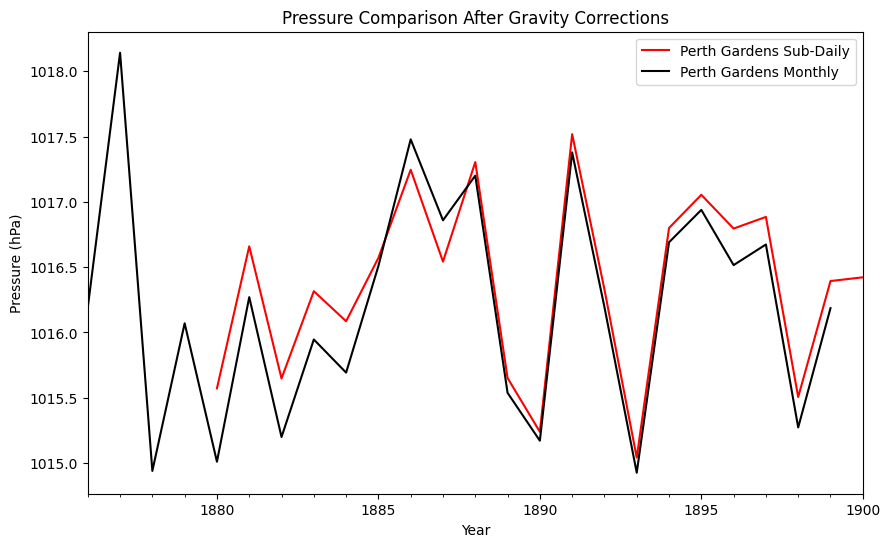

In [45]:
# Resample and plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed
PG_Pres_MSLP['MSLP'].resample('D').mean().resample('MS').mean().resample('YS').mean().plot(ax=ax, color='red')
PGm_Pres_MSLP['MSLP'].resample('YS').mean().plot(ax=ax, color='black')
# Customize the plot
plt.title('Pressure Comparison After Gravity Corrections')
plt.xlabel('Year')
plt.ylabel('Pressure (hPa)')
plt.legend(['Perth Gardens Sub-Daily','Perth Gardens Monthly'])
fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\Perth_Gardens_Sub_Daily_V_Monthly_Yrly.png", dpi=300, bbox_inches='tight')


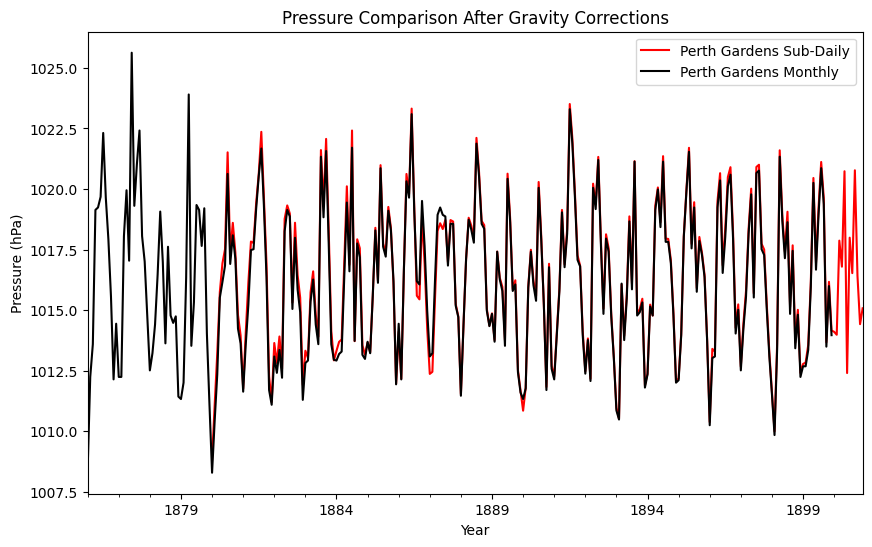

In [46]:
# Resample and plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed
PG_Pres_MSLP['MSLP'].resample('D').mean().resample('MS').mean().plot(ax=ax, color='red')
PGm_Pres_MSLP['MSLP'].plot(ax=ax, color='black')
# Customize the plot
plt.title('Pressure Comparison After Gravity Corrections')
plt.xlabel('Year')
plt.ylabel('Pressure (hPa)')
plt.legend(['Perth Gardens Sub-Daily','Perth Gardens Monthly'])
fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\Perth_Gardens_Sub_Daily_V_Monthly_Mthly.png", dpi=300, bbox_inches='tight')


In [47]:
X = pd.concat([PG_Pres_MSLP['MSLP'].resample('D').mean().resample('MS').mean(),PGm_Pres_MSLP['MSLP'].resample('MS').mean()],axis = 1)

In [48]:
(PG_Pres_MSLP['MSLP'].resample('D').mean().resample('MS').mean() - PGm_Pres_MSLP['MSLP'].resample('MS').mean()).dropna().loc['1884':'1885'].head(60)

Date
1884-01-01    0.402054
1884-02-01    0.499994
1884-03-01    0.502141
1884-04-01    0.556216
1884-05-01    0.670627
1884-06-01    0.269135
1884-07-01    0.709914
1884-08-01   -0.010409
1884-09-01    0.170955
1884-10-01    0.379567
1884-11-01    0.394342
1884-12-01    0.176351
1885-01-01   -0.030892
1885-02-01    0.036790
1885-03-01    0.007019
1885-04-01    0.107704
1885-05-01    0.068818
1885-06-01    0.125461
1885-07-01    0.129815
1885-08-01    0.159030
1885-09-01    0.158382
1885-10-01    0.096984
1885-11-01   -0.138519
1885-12-01    0.028179
Freq: MS, Name: MSLP, dtype: float64

1881-11-01   -7.388412 ISSUE FIXED DUE TO BEING A 30 AND IT SHOUDL AHVE BEEN 29.915

1884-08-01   -3.374457 ISSUE FIXED BY CALCUALTING MY OWN MONTHLY AVERAGE

1881-01-01   -1.999733 ISSUE FIXED BY ADDING THE MSLP SUBDIALY INTO THE DATASET WHCH WAS MISSING


In [49]:
PG_Pres_MSLP['MSLP'].loc['1881-01'].dropna()#.plot()

Date
1881-01-01 09:00:00    1016.320000
1881-01-01 12:00:00    1015.370000
1881-01-02 09:00:00    1015.870000
1881-01-02 12:00:00    1013.760000
1881-01-03 09:00:00    1009.440000
1881-01-03 12:00:00    1006.540000
1881-01-04 09:00:00    1009.940000
1881-01-04 12:00:00    1009.010000
1881-01-05 09:00:00    1009.130000
1881-01-05 12:00:00    1007.220000
1881-01-06 09:00:00    1004.140000
1881-01-06 12:00:00    1002.840000
1881-01-07 09:00:00    1007.200000
1881-01-07 12:00:00    1008.120000
1881-01-08 12:00:00    1009.024403
1881-01-09 12:00:00    1011.324097
1881-01-10 12:00:00    1013.488515
1881-01-11 12:00:00    1011.324097
1881-01-12 12:00:00    1006.183605
1881-01-13 12:00:00    1001.719494
1881-01-14 12:00:00    1011.324097
1881-01-15 12:00:00    1014.773638
1881-01-16 12:00:00    1012.879772
1881-01-17 12:00:00    1004.763206
1881-01-18 12:00:00    1011.459373
1881-01-19 12:00:00    1017.242426
1881-01-20 12:00:00    1019.542120
1881-01-21 12:00:00    1018.020264
1881-01-22 12:0

In [50]:
PGm_Pres_MSLP['MSLP'].loc['1881-01']
PG_Pres_MSLP['MSLP'].loc['1881-01'].dropna().mean()

np.float64(1011.3642022419066)

In [51]:
30.150*33.86
1012.19/33.86
PG_Pres_Trans.loc['1881-11'].dropna()/33.86

#IT IS NOT LINING UP CORRECTLY AND 30.150 IS NOT CORRECT EITHER

,Pressure (hPa)
Date,
1881-11-01 07:00:00,30.030006
1881-11-01 12:00:00,30.022002
1881-11-02 07:00:00,29.852008
1881-11-02 12:00:00,29.811991
1881-11-03 07:00:00,29.950000
1881-11-03 12:00:00,29.974011
1881-11-04 07:00:00,30.100000
1881-11-04 12:00:00,30.036001
1881-11-05 07:00:00,30.036001


<Axes: xlabel='Date'>

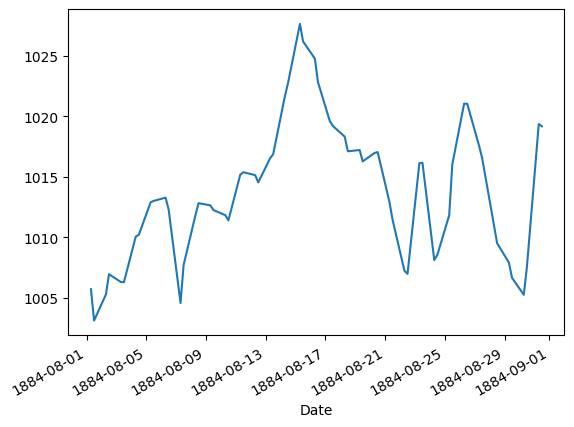

In [52]:
PG_Pres_MSLP['MSLP'].loc['1884-08'].dropna().plot()

In [53]:
(PG_Pres_MSLP.loc['1884-08'].dropna()/33.86).mean()
#Raw MB is correct as what is posted on the mean for month when average the bpttom two columns up

MSLP                         NaN
degC                         NaN
Raw mb                       NaN
Reduced Temp Pressure (mb)   NaN
Correct_Pres_Temp            NaN
CORRECTED                    NaN
Correct_temp_gravity_mslp    NaN
dtype: float64

In [54]:
PGm_Pres_Trans.loc['1884-08']

,inHg,Correct_temp_mslp
Date,,
1884-08-01,29.975,1014.9535


In [55]:
X = [29.836,
29.904,
29.968,
29.904,
29.752,
29.620,
29.904,
30.006,
29.950,
29.710,
29.908,
30.079,
30.147,
30.102,
29.930,
29.975,
29.940,
29.918,
29.997,
30.052,
30.017,
29.968,
29.952,
29.901]

In [56]:
GN = 980.665 #cms-2 OUTLINED BY 3.2.6.2
GO_80_84

#P = X *(GN/round(GO_80_84,3))

X*2

[29.836,
 29.904,
 29.968,
 29.904,
 29.752,
 29.62,
 29.904,
 30.006,
 29.95,
 29.71,
 29.908,
 30.079,
 30.147,
 30.102,
 29.93,
 29.975,
 29.94,
 29.918,
 29.997,
 30.052,
 30.017,
 29.968,
 29.952,
 29.901,
 29.836,
 29.904,
 29.968,
 29.904,
 29.752,
 29.62,
 29.904,
 30.006,
 29.95,
 29.71,
 29.908,
 30.079,
 30.147,
 30.102,
 29.93,
 29.975,
 29.94,
 29.918,
 29.997,
 30.052,
 30.017,
 29.968,
 29.952,
 29.901]

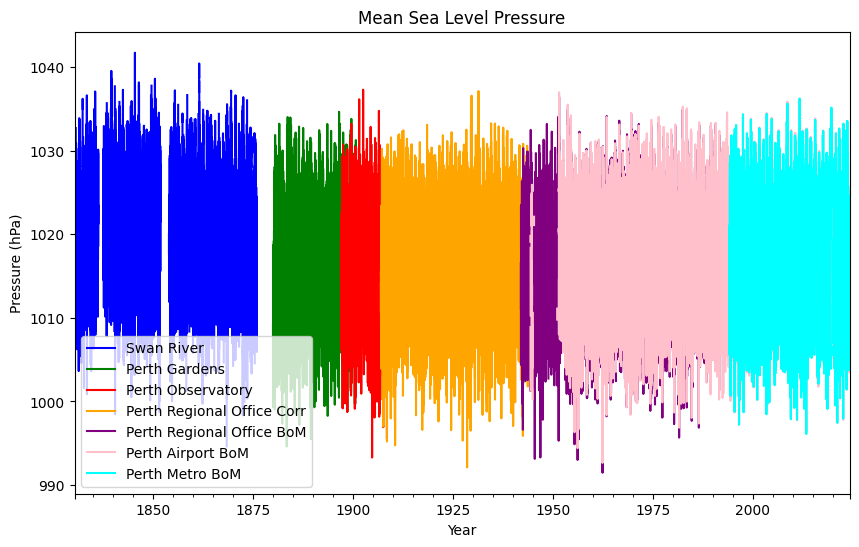

In [57]:
# Resample and plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed
SWR_Pres_MSLP['MSLP'].resample('D').mean().plot(ax=ax, color='blue')
PG_Pres_MSLP['MSLP'].resample('D').mean().plot(ax=ax, color='green')
PO_Pres_MSLP['MSLP'].resample('D').mean().plot(ax=ax, color='red')
PRO_Pres_MSLP['MSLP'].resample('D').mean().plot(ax=ax, color='orange')
#Monthly_Perth_Parallel['MSLP'].resample('Y').mean().plot(ax=ax, color='black')
PRO_Pres_BOM['MSLP'].resample('D').mean().plot(ax=ax,color= 'purple')
PA_Pres_BoM['MSLP'].resample('D').mean().plot(ax=ax,color= 'pink')
PM_Pres_BoM['MSLP'].resample('D').mean().plot(ax=ax,color= 'cyan')
PA_Pres_BoM_2['MSLP'].resample('D').mean().plot(ax=ax,color= 'pink')
PM_Pres_BoM_2['MSLP'].resample('D').mean().plot(ax=ax,color= 'cyan')

# Customize the plot
plt.title('Mean Sea Level Pressure')
plt.xlabel('Year')
plt.ylabel('Pressure (hPa)')
plt.legend(['Swan River','Perth Gardens','Perth Observatory','Perth Regional Office Corr','Perth Regional Office BoM',
           'Perth Airport BoM', 'Perth Metro BoM'])
plt.show()

# 7. NOTING ALL UPDATES FROM TRANSCRIPTION ISSUES AND ERRORS

## PERTH GARDENS

There was no January As Read pressure for Perth Gardens in 1881. However, what we did have was the Adjusted Perth Gardens record whcih was corrected by Temperature and MSLP. This is similar to the Perth Observatory record. Therefore, all I needed to do was to reduce the record by gravity to get it into a MSLP state and it onto the Perth Gardens MSLP dataset.



## PERTH OBSERVATORY
## SWAN RIVER


## PERTH REGIONAL OFFICE

This dataset is the most delicate dataset of the entire record. Without this record fixed properly, the 19th century cannot be compared to the 21st century pressure for Perth. What do we know; we know that significant rainfall events occured in the mid 1910s, we also know that the height and location of the barometer from 1907-1941. However, from 1942, we still are not able to identify the date at which the height change occurs and whether the barometer was a kew pattern within the first 9 months of 1942. We also do not know if the barometer was always a kew pattern barometer. However we need understand the differences in the barometer choice do not cause significant impacts on the final MSLP product (referring to box plots earlier in this coding file).

# 8. SAVING METADATA   

In [58]:
SWR_Pres_MSLP[['MSLP']].to_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\SWAN_RIVER_PRESSURE_MSLP_SUBDAILY_1830-1875.csv")
PG_Pres_MSLP[['MSLP']].to_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_GARDENS_PRESSURE_MSLP_SUBDAILY_1880-1900.csv")
PO_Pres_MSLP[['MSLP']].to_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_OBSERVATORY_PRESSURE_MSLP_SUBDAILY_1897-1908.csv")
PRO_Pres_MSLP[['MSLP']].to_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_REGIONAL_OFFICE_PRESSURE_MSLP_SUBDAILY_1907-1944.csv")
PGm_Pres_MSLP[['MSLP']].to_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_GARDENS_PRESSURE_MSLP_MONTHLY_1876-1899.csv")


# 9. VERIFY THE EXTREME PRESSURE CHANGES IN PERTH GARDENS VS PERTH OBSERVATORY

<Axes: xlabel='Date'>

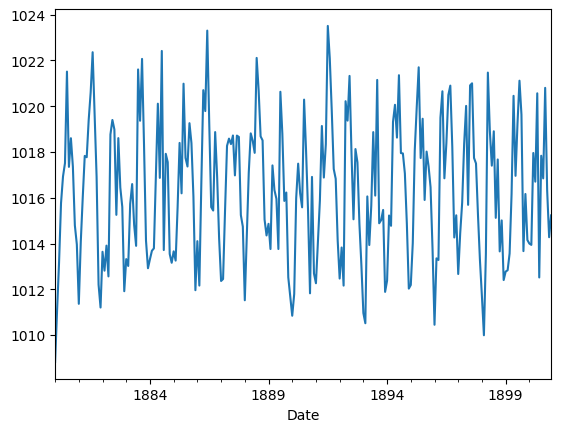

In [59]:
PG_Pres_MSLP['MSLP'].resample('ME').mean().plot()

<Axes: xlabel='Date'>

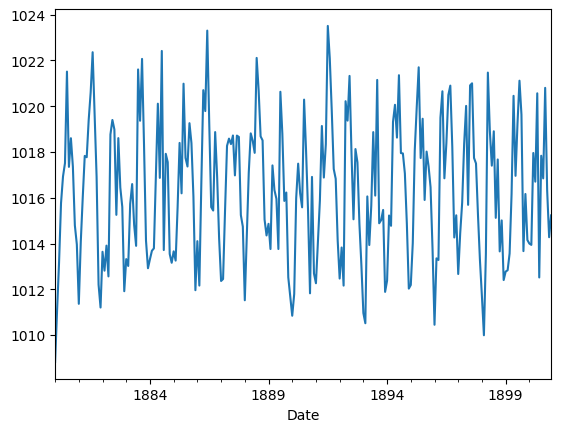

In [60]:
PG_Pres_MSLP['MSLP'].resample('ME').mean().plot()

In [61]:
SWR_Pres_Trans = SWR_Pres_Trans*33.86
PO_Pres_Trans = PO_Pres_Trans*33.86
PRO_Pres_Trans = PRO_Pres_Trans*33.86

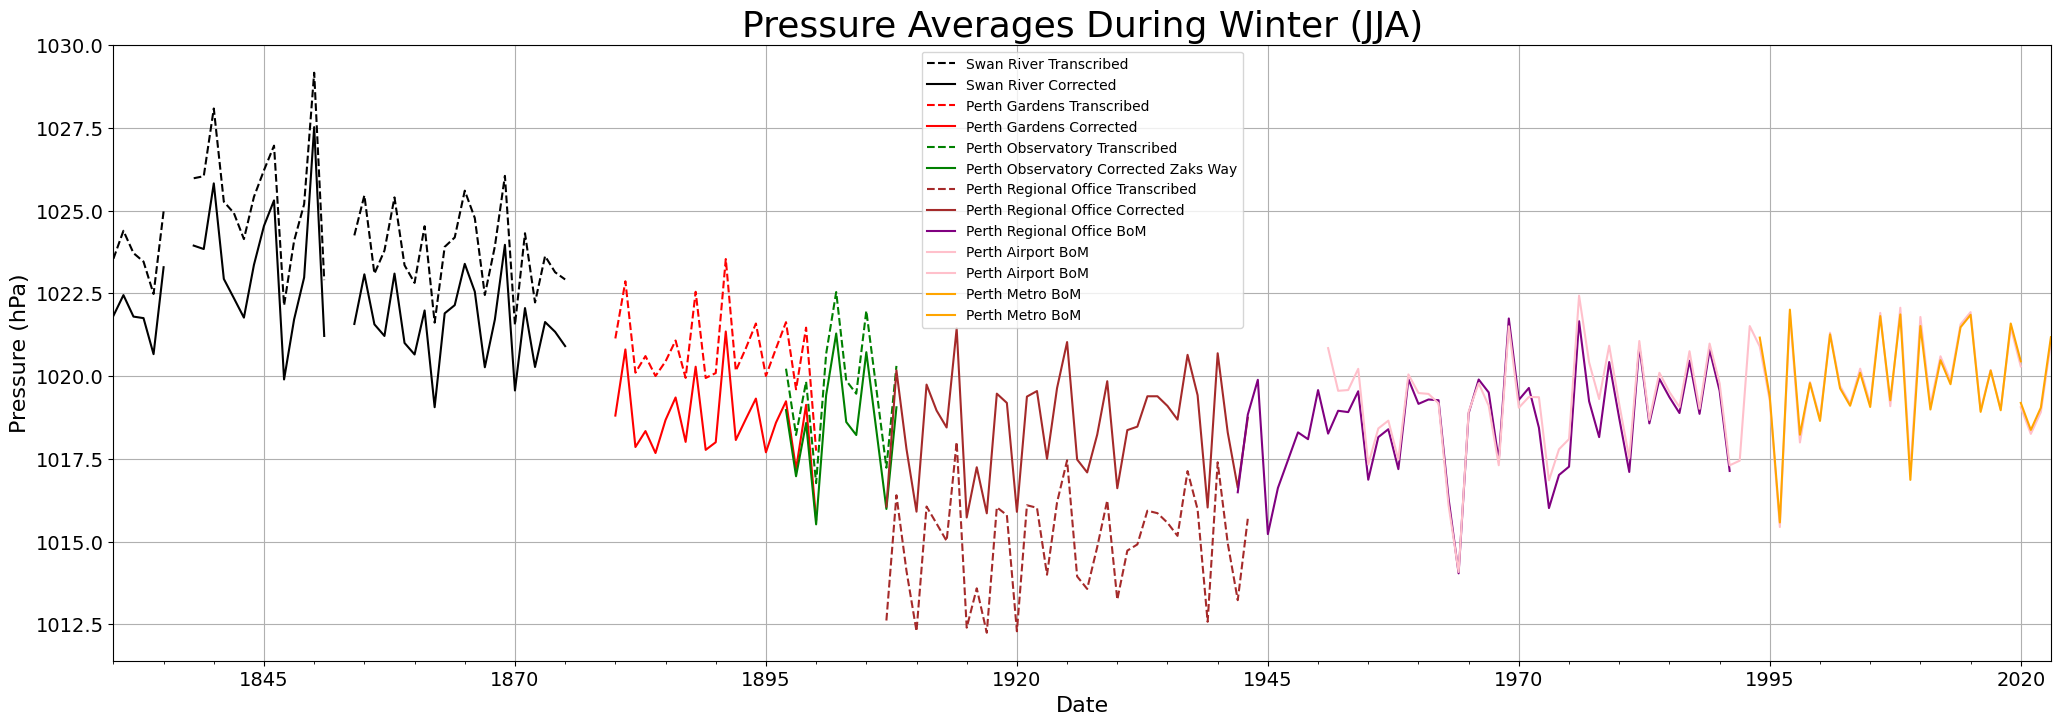

In [62]:
# ORIGINAL ONE
fig, ax = plt.subplots(figsize=(25, 8))  # Adjust the figsize as needed
SWR_Pres_Trans[(SWR_Pres_Trans.index.month == 6) | (SWR_Pres_Trans.index.month == 7) | (SWR_Pres_Trans.index.month == 8)]['Pressure (inHg)'].resample('D').mean().resample('YE').mean().plot(ax=ax,linestyle = '--',color= 'black')
SWR_Pres_MSLP[(SWR_Pres_MSLP.index.month == 6) | (SWR_Pres_MSLP.index.month == 7) | (SWR_Pres_MSLP.index.month == 8)]['MSLP'].resample('D').mean().resample('YE').mean().plot(ax=ax,linestyle = '-',color= 'black')

PG_Pres_Trans[(PG_Pres_Trans.index.month == 6) | (PG_Pres_Trans.index.month == 7) | (PG_Pres_Trans.index.month == 8)]['Pressure (hPa)'].resample('D').mean().resample('YE').mean().plot(ax=ax,linestyle = '--',color= 'red')
PG_Pres_MSLP[(PG_Pres_MSLP.index.month == 6) | (PG_Pres_MSLP.index.month == 7) | (PG_Pres_MSLP.index.month == 8)]['MSLP'].resample('D').mean().resample('YE').mean().plot(ax=ax,linestyle = '-',color= 'red')


PO_Pres_Trans[(PO_Pres_Trans.index.month == 6) | (PO_Pres_Trans.index.month == 7) | (PO_Pres_Trans.index.month == 8)]['Pressure (inHg)'].resample('D').mean().resample('YE').mean().plot(ax=ax,linestyle = '--',color= 'green')
PO_Pres_MSLP[(PO_Pres_MSLP.index.month == 6) | (PO_Pres_MSLP.index.month == 7) | (PO_Pres_MSLP.index.month == 8)]['MSLP'].resample('D').mean().resample('YE').mean().plot(ax=ax,color= 'green')

PRO_Pres_Trans[(PRO_Pres_Trans.index.month == 6) | (PRO_Pres_Trans.index.month == 7) | (PRO_Pres_Trans.index.month == 8)]['inHg'].resample('D').mean().resample('YE').mean().plot(ax=ax,linestyle = '--',color= 'brown')
PRO_Pres_MSLP[(PRO_Pres_MSLP.index.month == 6) | (PRO_Pres_MSLP.index.month == 7) | (PRO_Pres_MSLP.index.month == 8)]['MSLP'].resample('D').mean().resample('YE').mean().plot(ax=ax,color= 'brown')


PRO_Pres_BOM[(PRO_Pres_BOM.index.month == 6) | (PRO_Pres_BOM.index.month == 7) | (PRO_Pres_BOM.index.month == 8)]['MSLP'].resample('D').mean().resample('YE').mean().plot(ax=ax,color= 'purple')

PA_Pres_BoM[(PA_Pres_BoM.index.month == 6) | (PA_Pres_BoM.index.month == 7) | (PA_Pres_BoM.index.month == 8)]['MSLP'].resample('D').mean().resample('YE').mean().plot(ax=ax,color= 'pink')
PA_Pres_BoM_2[(PA_Pres_BoM_2.index.month == 6) | (PA_Pres_BoM_2.index.month == 7) | (PA_Pres_BoM_2.index.month == 8)]['MSLP'].resample('D').mean().resample('YE').mean().plot(ax=ax,color= 'pink')

PM_Pres_BoM[(PM_Pres_BoM.index.month == 6) | (PM_Pres_BoM.index.month == 7) | (PM_Pres_BoM.index.month == 8)]['MSLP'].resample('D').mean().resample('YE').mean().plot(ax=ax,color= 'orange')
PM_Pres_BoM_2[(PM_Pres_BoM_2.index.month == 6) | (PM_Pres_BoM_2.index.month == 7) | (PM_Pres_BoM_2.index.month == 8)]['MSLP'].resample('D').mean().resample('YE').mean().plot(ax=ax,color= 'orange')


ax.legend(['Swan River Transcribed','Swan River Corrected',
           'Perth Gardens Transcribed','Perth Gardens Corrected',
           'Perth Observatory Transcribed','Perth Observatory Corrected Zaks Way',
           'Perth Regional Office Transcribed','Perth Regional Office Corrected',
          'Perth Regional Office BoM',
           'Perth Airport BoM','Perth Airport BoM',
           'Perth Metro BoM','Perth Metro BoM'])

ax.set_title('Pressure Averages During Winter (JJA)',fontsize = 26)
ax.set_xlabel('Date',fontsize = 16)
ax.set_ylabel('Pressure (hPa)',fontsize = 16)
# Adjust tick label sizes
ax.tick_params(axis='both', labelsize=14)  # For x-axis tick labels

ax.grid()



In [63]:
PGm_Pres_Trans = PGm_Pres_Trans*33.86


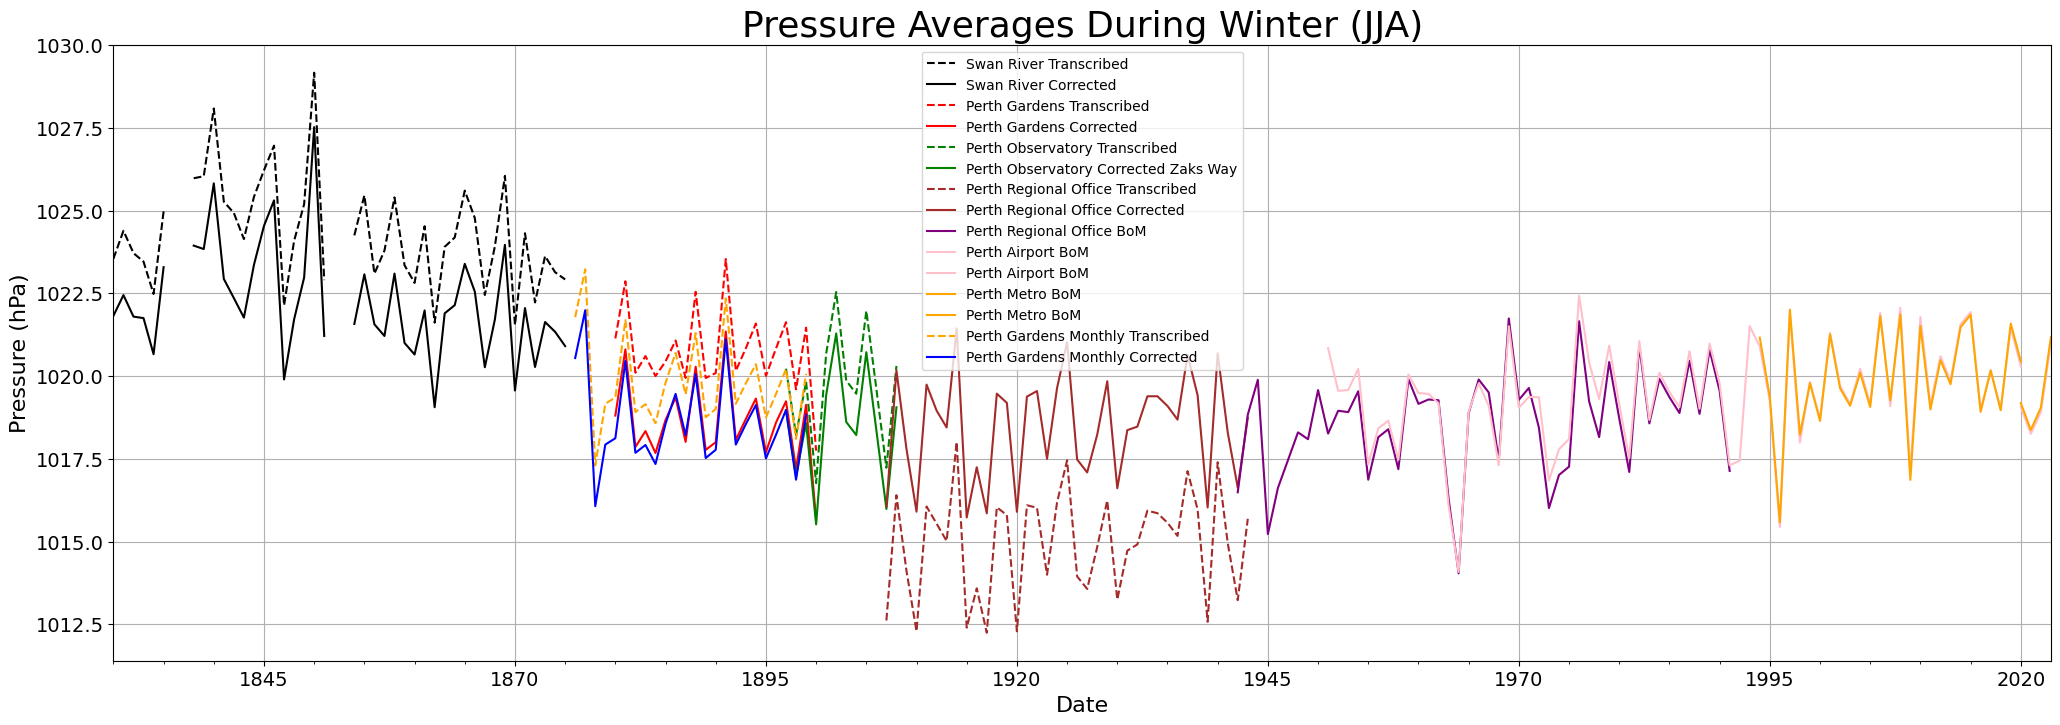

In [64]:
# ORIGINAL ONE
fig, ax = plt.subplots(figsize=(25, 8))  # Adjust the figsize as needed
SWR_Pres_Trans[(SWR_Pres_Trans.index.month == 6) | (SWR_Pres_Trans.index.month == 7) | (SWR_Pres_Trans.index.month == 8)]['Pressure (inHg)'].resample('D').mean().resample('YE').mean().plot(ax=ax,linestyle = '--',color= 'black')
SWR_Pres_MSLP[(SWR_Pres_MSLP.index.month == 6) | (SWR_Pres_MSLP.index.month == 7) | (SWR_Pres_MSLP.index.month == 8)]['MSLP'].resample('D').mean().resample('YE').mean().plot(ax=ax,linestyle = '-',color= 'black')

PG_Pres_Trans[(PG_Pres_Trans.index.month == 6) | (PG_Pres_Trans.index.month == 7) | (PG_Pres_Trans.index.month == 8)]['Pressure (hPa)'].resample('D').mean().resample('YE').mean().plot(ax=ax,linestyle = '--',color= 'red')
PG_Pres_MSLP[(PG_Pres_MSLP.index.month == 6) | (PG_Pres_MSLP.index.month == 7) | (PG_Pres_MSLP.index.month == 8)]['MSLP'].resample('D').mean().resample('YE').mean().plot(ax=ax,linestyle = '-',color= 'red')


PO_Pres_Trans[(PO_Pres_Trans.index.month == 6) | (PO_Pres_Trans.index.month == 7) | (PO_Pres_Trans.index.month == 8)]['Pressure (inHg)'].resample('D').mean().resample('YE').mean().plot(ax=ax,linestyle = '--',color= 'green')
PO_Pres_MSLP[(PO_Pres_MSLP.index.month == 6) | (PO_Pres_MSLP.index.month == 7) | (PO_Pres_MSLP.index.month == 8)]['MSLP'].resample('D').mean().resample('YE').mean().plot(ax=ax,color= 'green')

PRO_Pres_Trans[(PRO_Pres_Trans.index.month == 6) | (PRO_Pres_Trans.index.month == 7) | (PRO_Pres_Trans.index.month == 8)]['inHg'].resample('D').mean().resample('YE').mean().plot(ax=ax,linestyle = '--',color= 'brown')
PRO_Pres_MSLP[(PRO_Pres_MSLP.index.month == 6) | (PRO_Pres_MSLP.index.month == 7) | (PRO_Pres_MSLP.index.month == 8)]['MSLP'].resample('D').mean().resample('YE').mean().plot(ax=ax,color= 'brown')


PRO_Pres_BOM[(PRO_Pres_BOM.index.month == 6) | (PRO_Pres_BOM.index.month == 7) | (PRO_Pres_BOM.index.month == 8)]['MSLP'].resample('D').mean().resample('YE').mean().plot(ax=ax,color= 'purple')

PA_Pres_BoM[(PA_Pres_BoM.index.month == 6) | (PA_Pres_BoM.index.month == 7) | (PA_Pres_BoM.index.month == 8)]['MSLP'].resample('D').mean().resample('YE').mean().plot(ax=ax,color= 'pink')
PA_Pres_BoM_2[(PA_Pres_BoM_2.index.month == 6) | (PA_Pres_BoM_2.index.month == 7) | (PA_Pres_BoM_2.index.month == 8)]['MSLP'].resample('D').mean().resample('YE').mean().plot(ax=ax,color= 'pink')

PM_Pres_BoM[(PM_Pres_BoM.index.month == 6) | (PM_Pres_BoM.index.month == 7) | (PM_Pres_BoM.index.month == 8)]['MSLP'].resample('D').mean().resample('YE').mean().plot(ax=ax,color= 'orange')
PM_Pres_BoM_2[(PM_Pres_BoM_2.index.month == 6) | (PM_Pres_BoM_2.index.month == 7) | (PM_Pres_BoM_2.index.month == 8)]['MSLP'].resample('D').mean().resample('YE').mean().plot(ax=ax,color= 'orange')

PGm_Pres_Trans[(PGm_Pres_Trans.index.month == 6) | (PGm_Pres_Trans.index.month == 7) | (PGm_Pres_Trans.index.month == 8)]['inHg'].resample('D').mean().resample('YE').mean().plot(ax=ax,linestyle = '--',color= 'orange')
PGm_Pres_MSLP[(PGm_Pres_MSLP.index.month == 6) | (PGm_Pres_MSLP.index.month == 7) | (PGm_Pres_MSLP.index.month == 8)]['MSLP'].resample('D').mean().resample('YE').mean().plot(ax=ax,color= 'blue')


ax.legend(['Swan River Transcribed','Swan River Corrected',
           'Perth Gardens Transcribed','Perth Gardens Corrected',
           'Perth Observatory Transcribed','Perth Observatory Corrected Zaks Way',
           'Perth Regional Office Transcribed','Perth Regional Office Corrected',
          'Perth Regional Office BoM',
           'Perth Airport BoM','Perth Airport BoM',
           'Perth Metro BoM','Perth Metro BoM',
          'Perth Gardens Monthly Transcribed','Perth Gardens Monthly Corrected'])

ax.set_title('Pressure Averages During Winter (JJA)',fontsize = 26)
ax.set_xlabel('Date',fontsize = 16)
ax.set_ylabel('Pressure (hPa)',fontsize = 16)
# Adjust tick label sizes
ax.tick_params(axis='both', labelsize=14)  # For x-axis tick labels

ax.grid()
#fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\AS_READ_MSLP_COMPARISON_WINTER_JJA", dpi=300, bbox_inches='tight')


<Axes: xlabel='Date'>

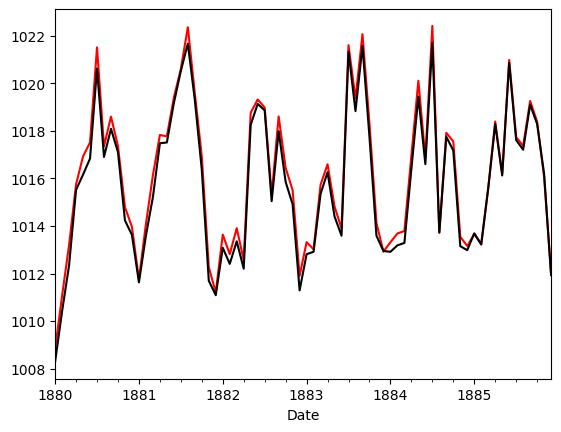

In [65]:
PG_Pres_MSLP['MSLP'].loc['1880':'1885'].resample('D').mean().resample('MS').mean().plot(color='red')
PGm_Pres_MSLP['MSLP'].loc['1880':'1885'].plot(color='black')

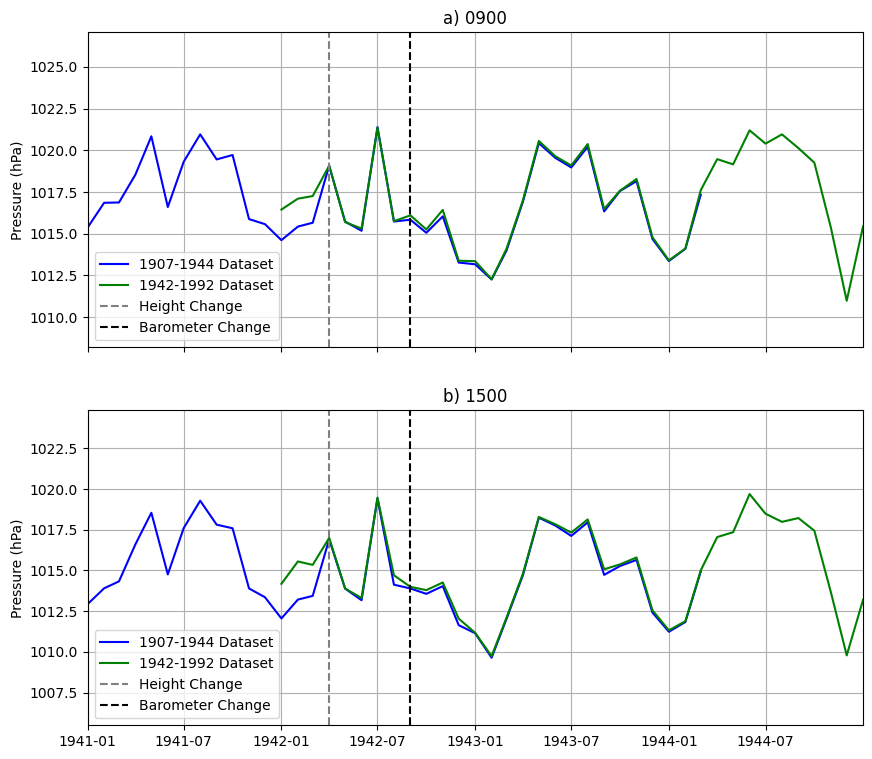

In [67]:
# Define your date limits
xlim_L_Y = 1939
xlim_U_Y = 1945
xlim_L = datetime(1941, 1, 1)
xlim_U = datetime(1944, 12, 31)
xlim = [xlim_L, xlim_U]
xlim_Y = [xlim_L_Y , xlim_U_Y ]

xvline =  datetime(1942, 4, 1)
xvline2 =  datetime(1942, 9, 1)


#9am Pressure
fig, (ax3,ax4) = plt.subplots(2, 1, figsize=(10, 9), sharex=True)
ax=ax3
ax.plot(PRO_Pres_MSLP[PRO_Pres_MSLP.index.hour==9]['MSLP'].resample('D').mean().resample('MS').mean().loc[:'2023'], color='b', label='1907-1944 Dataset')
ax.plot(PRO_Pres_BOM[PRO_Pres_BOM.index.hour==9]['MSLP'].resample('D').mean().resample('MS').mean().loc[:'2023'], color='g', label='1942-1992 Dataset')

ax.set_ylabel('Pressure (hPa)')
ax.set_xlim(xlim)
ax.axvline(x=xvline, color='grey', linestyle='--', label='Height Change')
ax.axvline(x=xvline2, color='black', linestyle='--', label='Barometer Change')
ax.legend(loc = 'lower left')
ax.set_title('a) 0900')
ax.grid()


#9am Pressure
ax=ax4
ax.plot(PRO_Pres_MSLP[PRO_Pres_MSLP.index.hour==15]['MSLP'].resample('D').mean().resample('MS').mean().loc[:'2023'], color='b', label='1907-1944 Dataset')
ax.plot(PRO_Pres_BOM[PRO_Pres_BOM.index.hour==15]['MSLP'].resample('D').mean().resample('MS').mean().loc[:'2023'], color='g', label='1942-1992 Dataset')

ax.set_ylabel('Pressure (hPa)')
ax.set_xlim(xlim)
ax.axvline(x=xvline, color='grey', linestyle='--', label='Height Change')
ax.axvline(x=xvline2, color='black', linestyle='--', label='Barometer Change')
ax.legend(loc = 'lower left')
ax.set_title('b) 1500')
ax.grid()
fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\S2_PRO_US_BOM_COMPARISON_1941_1944_3PM", dpi=300, bbox_inches='tight')
fig.savefig(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Figure files\Direct From Script\S2_PRO_US_BOM_COMPARISON_1941_1944.png", dpi=300, bbox_inches='tight')


# 10. TATT VS TDB

We want to show how temperature impacts MSLP pressure on the same record, therefore we want to look at correlation p value at 0.85 or 0.99 level and see how different they are on a box plot, we will also look at +5 and -5degC to also show how the impact on thermometer that may be in a different spot then the barometer can have on the final MSLP value. Therefore providing a valuable assessment on the impact of Temperature in getting the pressure to MSLP. This will be in reference to the 1907-1942 period of the Perth Regional Office record as we have both Tatt and Tdb to use for pressure and for different times.

How to proceed:
1. correlation between AS READ PRESSURE AND TATT AND TDB, expecting TATT to have a higher correlation

   on 9am, 3pm and 9pm, and also overall to, 0.85 and 0.99
3. Applying the AS READ TO MSLP TO THE DIFFERENT DATASETS AND THE -5+5DEGC and show them as box plots

   on 9am 3pm and 9pm
5. correlation between MSLP AND TATT AND TDB, expecting TATT to still have a higher correlation



In [106]:
# TATT
TATTP = round(PRO_Pres_Trans.loc['1907':'1941'],2)
TATT = PRO_Temp_Trans.loc['1907':'1941']
TATT = round(((TATT-32)*(5/9)),1).loc['1907':'1941']

#TDB
TDBP = PRO_Pres_Trans_DB.loc['1907':'1941']
TDB = PRO_Temp_DB.loc['1907':'1941']


In [107]:
# 1. CORRELATION ON THE TRANSCRIBED SIDE OF THINGS
Temp_Correlation = pd.concat([TATTP['inHg'],TDB['degC'], TATT['degF']], axis= 1)
Temp_Correlation = Temp_Correlation.dropna()
## TATT VS TDB
corr_Temp_Comp, p_value = pearsonr(Temp_Correlation['degC'], Temp_Correlation['degF'])

TDB_TATT= ChatJR.corr_sig(Temp_Correlation['degC'], Temp_Correlation['degF'])


In [108]:
## P VS TATT
corr_Temp_Comp, p_value = pearsonr(Temp_Correlation['inHg'], Temp_Correlation['degF'])
P_ATT = ChatJR.corr_sig(Temp_Correlation['inHg'], Temp_Correlation['degF'])


In [109]:
## P VS TDB
corr_Temp_Comp, p_value = pearsonr(Temp_Correlation['degC'], Temp_Correlation['inHg'])
P_TDB = ChatJR.corr_sig(Temp_Correlation['degC'], Temp_Correlation['inHg'])


In [110]:
Corr_Data = pd.DataFrame(TDB_TATT)
Corr_Data.columns = ['Attached Thermometer / Dry Bulb Temperature']

Corr_Data_New = pd.DataFrame(P_ATT)
Corr_Data_New.columns = ['As Read Pressure Perth Regional Office / Attached Thermometer']
Corr_Data = pd.concat([Corr_Data,Corr_Data_New], axis = 1)

Corr_Data_New = pd.DataFrame(P_TDB)
Corr_Data_New.columns = ['As Read Pressure Perth Regional Office / Dry Bulb Temperature']
Corr_Data = pd.concat([Corr_Data,Corr_Data_New], axis = 1)

Corr_Data.to_csv(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Manuscript files\Correlation_Summary_TATT_TDB.csv")
Corr_Data

,Attached Thermometer / Dry Bulb Temperature,As Read Pressure Perth Regional Office / Attached Thermometer,As Read Pressure Perth Regional Office / Dry Bulb Temperature
Correlation,0.9,-0.34,-0.29
p_value,0.0,0.0,0.0
Significance,99%,99%,99%


Theory was correct, we see that there is a weak correlation and higher in Attached thermometer compared to dry bulb temperature (p = 0.34 to 0.29).

So this means temperature weakly explains the pressure value at any given time, but does have a slight influence on the pressure overall, but the difference in the r value is small enough to be able to use the Tdb instead of the Tatt if we do not have Tatt avalaible. 

In [111]:
# Now box plot these, based on time of the year etc

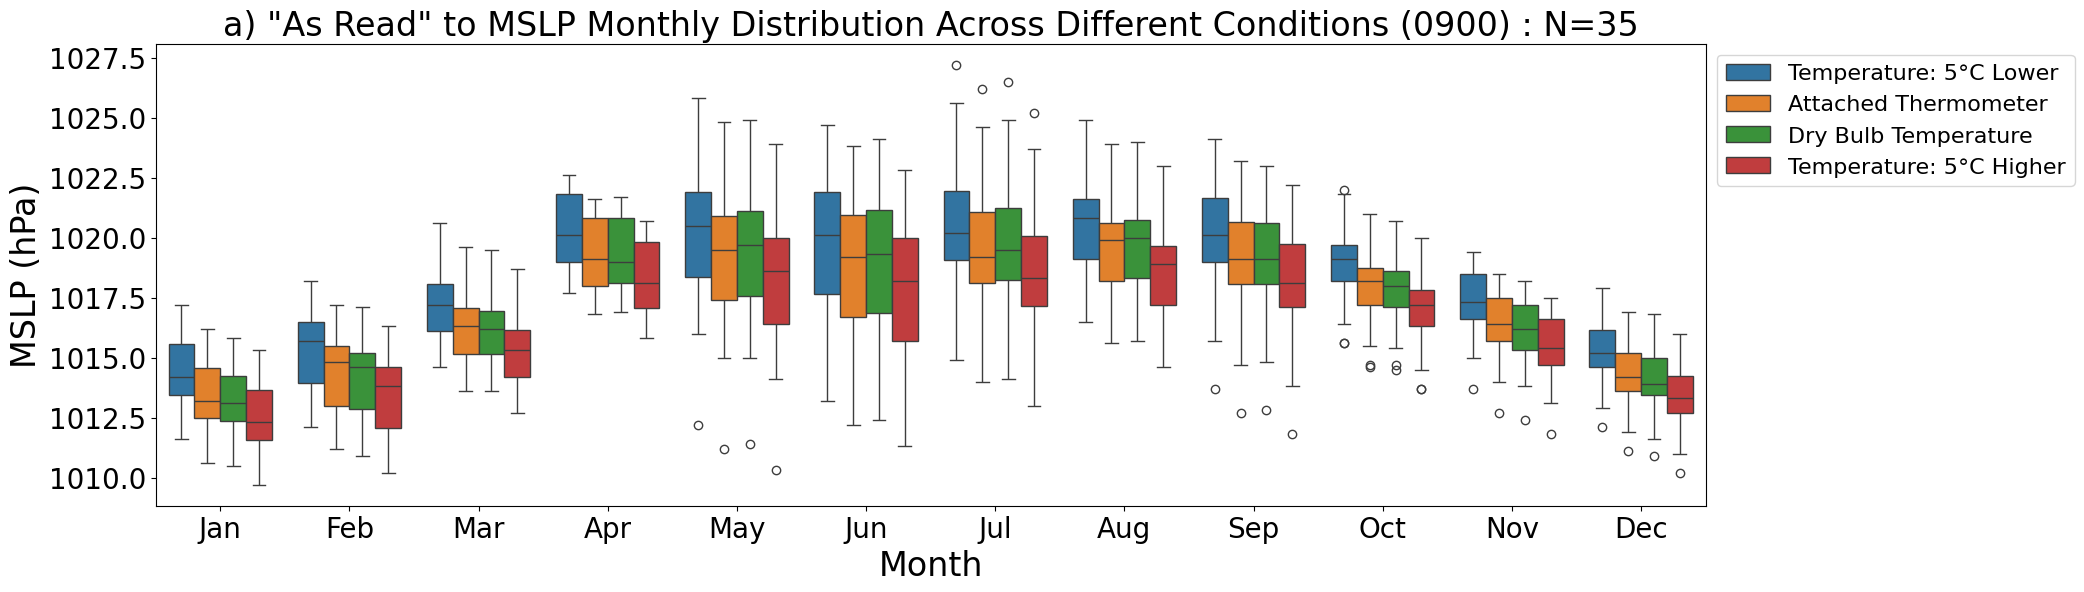

In [25]:
DATA = DIFFERENCES_MSLP_9[['Temperature: 5°C Lower', 'Original + Fortin + Attached Thermometer','Dry Bulb Temperature','Temperature: 5°C Higher']]

DATA = DATA.rename(columns={'Original + Fortin + Attached Thermometer': 'Attached Thermometer'})
# Extract Month and Year
DATA["Year"] = DATA.index.year
DATA["Month"] = DATA.index.month
LENGTH  = len(DATA.resample('YS').mean())


# Melt the dataframe to convert columns into a long format for seaborn
df_melted = DATA.melt(id_vars=["Year", "Month"], var_name="Category", value_name="MSLP")

# Create a grid of box plots, one per month
fig = plt.figure(figsize=(20, 6))
sns.boxplot(x=df_melted["Month"], y=df_melted["MSLP"], hue=df_melted["Category"])

# Formatting
plt.xlabel("Month",fontsize = 24)
plt.ylabel("MSLP (hPa)",fontsize = 24)
plt.title("a) \"As Read\" to MSLP Monthly Distribution Across Different Conditions (0900) : N={}".format(LENGTH),fontsize = 24)
plt.xticks(ticks=range(12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],fontsize = 20)
plt.legend(title="", bbox_to_anchor=(1.0, 1), loc="upper left",fontsize = 16)
plt.yticks(fontsize = 20)
fig.savefig(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Figure files\Direct From Script\S1_TEMP_TO_MSLP_COMPARISONS_9AM.png", dpi=300, bbox_inches='tight')

# Show the plot


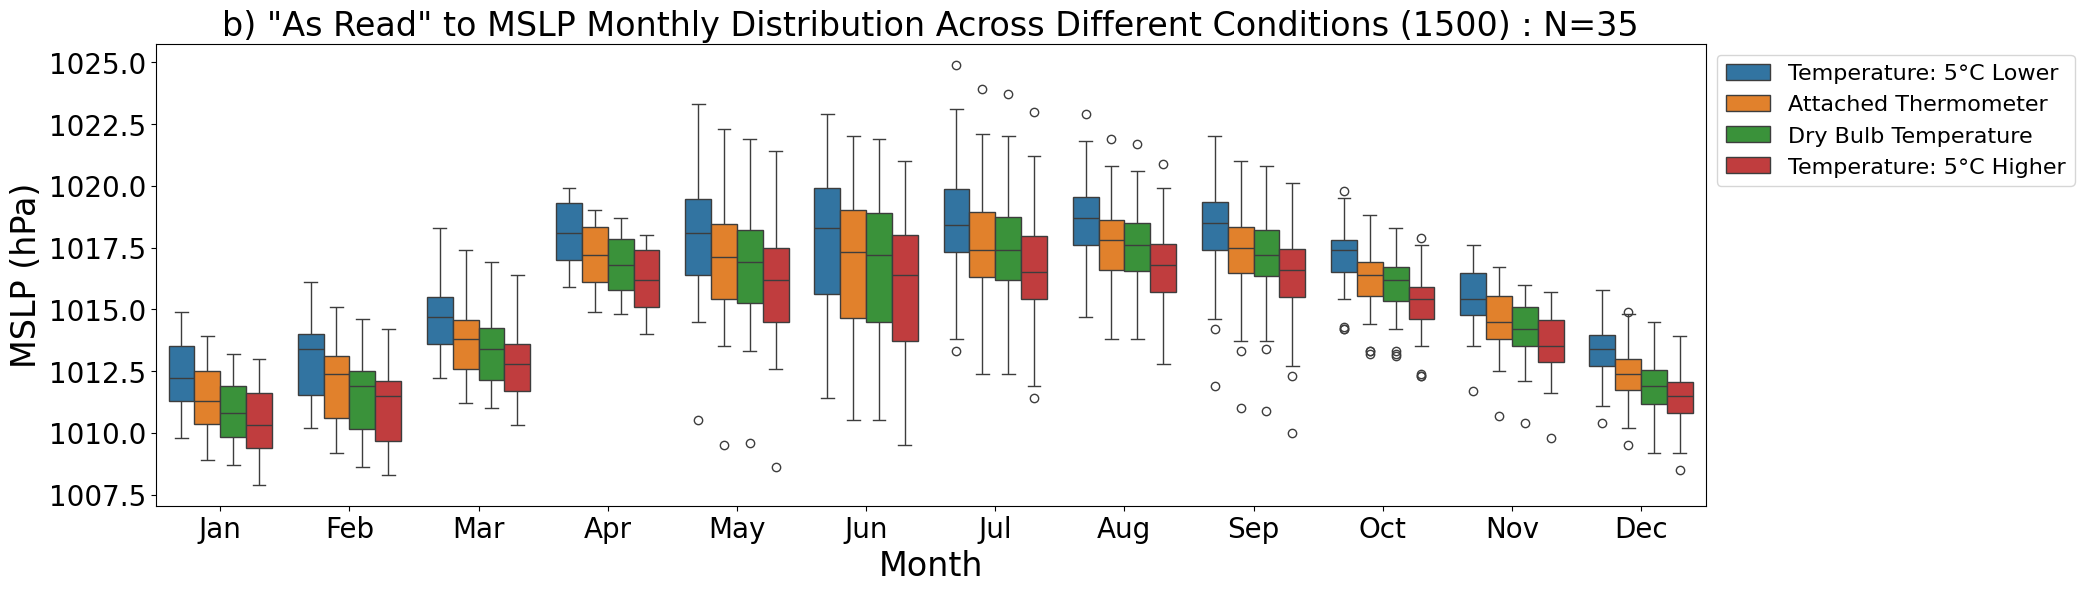

In [26]:
DATA = DIFFERENCES_MSLP_15[['Temperature: 5°C Lower', 'Original + Fortin + Attached Thermometer','Dry Bulb Temperature','Temperature: 5°C Higher']]

DATA = DATA.rename(columns={'Original + Fortin + Attached Thermometer': 'Attached Thermometer'})
# Extract Month and Year
DATA["Year"] = DATA.index.year
DATA["Month"] = DATA.index.month
LENGTH  = len(DATA.resample('YS').mean())


# Melt the dataframe to convert columns into a long format for seaborn
df_melted = DATA.melt(id_vars=["Year", "Month"], var_name="Category", value_name="MSLP")

# Create a grid of box plots, one per month
fig = plt.figure(figsize=(20, 6))
sns.boxplot(x=df_melted["Month"], y=df_melted["MSLP"], hue=df_melted["Category"])

# Formatting
plt.xlabel("Month",fontsize = 24)
plt.ylabel("MSLP (hPa)",fontsize = 24)
plt.title("b) \"As Read\" to MSLP Monthly Distribution Across Different Conditions (1500) : N={}".format(LENGTH),fontsize = 24)
plt.xticks(ticks=range(12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],fontsize = 20)
plt.legend(title="", bbox_to_anchor=(1.0, 1), loc="upper left",fontsize = 16)
plt.yticks(fontsize = 20)

# Show the plot
fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\S1_TEMP_TO_MSLP_COMPARISONS_3PM.png", dpi=300, bbox_inches='tight')
fig.savefig(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Figure files\Direct From Script\S1_TEMP_TO_MSLP_COMPARISONS_3PM.png", dpi=300, bbox_inches='tight')


In [114]:
# 5. CORRELATION BETWEEN MSLP AND TATT ETC
# TATT
TATTM = round(Normal.loc['1907':'1941'],2)
TATT = PRO_Temp_Trans.loc['1907':'1941']
TATT = round(((TATT-32)*(5/9)),1).loc['1907':'1941']

#TDB
TDBM = TEMP_DB.loc['1907':'1941']
TDB = PRO_Temp_DB.loc['1907':'1941']


In [115]:
TATTM_COMP= pd.concat([TATTM['Original + Fortin + Attached Thermometer'], Temp_Correlation['degF']], axis = 1).dropna()
TDB_COMP= pd.concat([TDBM['Dry Bulb Temperature'], Temp_Correlation['degC']], axis = 1).dropna()


In [116]:
## P VS TATT
corr_Temp_Comp, p_value = pearsonr(TATTM_COMP['Original + Fortin + Attached Thermometer'], TATTM_COMP['degF'])
ChatJR.corr_sig(TATTM_COMP['Original + Fortin + Attached Thermometer'], TATTM_COMP['degF'])


Correlation    -0.45
p_value          0.0
Significance     99%
dtype: object

In [117]:
## P VS TDB
corr_Temp_Comp, p_value = pearsonr(TDB_COMP['Dry Bulb Temperature'], TDB_COMP['degC'])
ChatJR.corr_sig(TDB_COMP['Dry Bulb Temperature'], TDB_COMP['degC'])

Correlation    -0.44
p_value          0.0
Significance     99%
dtype: object

So what we see is that the MSLP is influenced by the temperature given, we see that from the as read correlations, the correlations now are identical which indicates that the mslp value before any corrections and is significantly influenced by which temperature is used in the final product. Therefore we can understand through the boxplots that in the summer months, the difference between the the pressure is up to one hPa between Tdb and Tatt. However, moving outside the range to a +5 or -5degC we can see that difference can be up to 2 hPa. Albiet, the RHTest and other algoirthms should in fact fix this issue as when we eventually combine all the datasets together.


# CONVERTING TO 20CR DATA

In [153]:
SWR_River_Temp_Corrected
Perth_Gardens_Temp_Corrected
Perth_Observatory_Temp_Corrected
Perth_Regional_Temp_Corrected = Perth_Regional_Temp_Corrected.loc[:'1910']



In [154]:
Perth_Observatory_Temp_Corrected['Pressure'] = pd.to_numeric(Perth_Observatory_Temp_Corrected['Pressure'], errors='coerce')


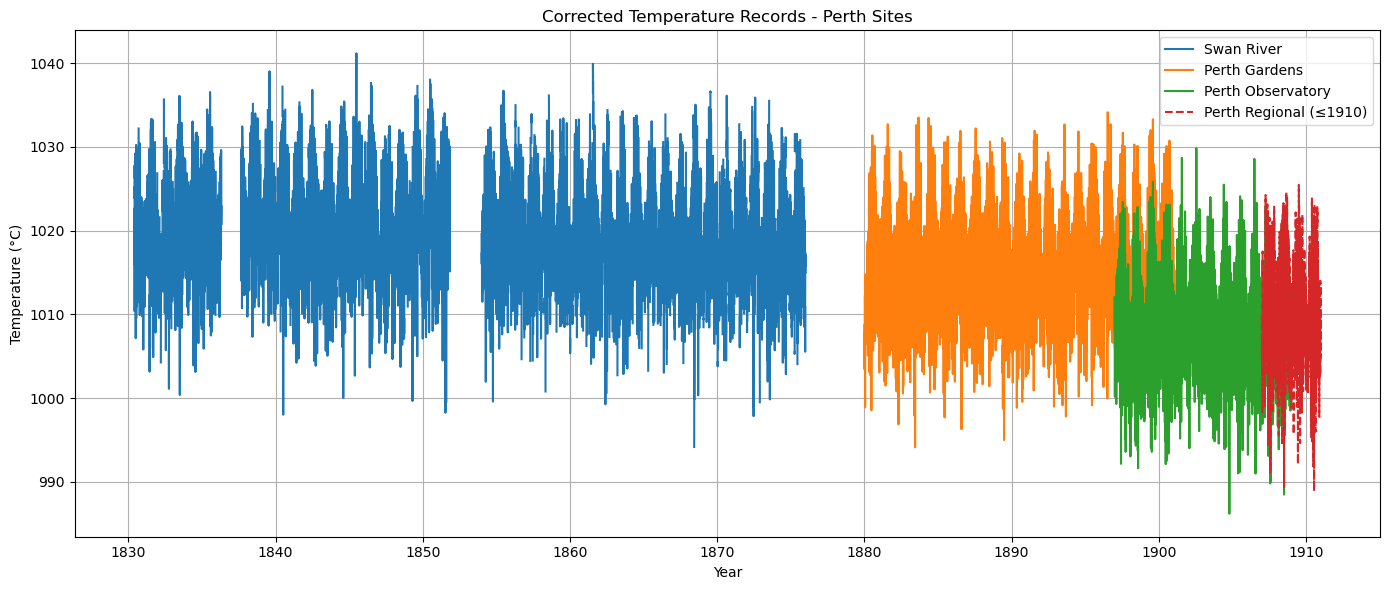

In [155]:
import matplotlib.pyplot as plt


# Plot
plt.figure(figsize=(14, 6))
plt.plot(SWR_River_Temp_Corrected['Reduced Temp Pressure (mb)'].resample('D').mean('YS'), label='Swan River')
plt.plot(Perth_Gardens_Temp_Corrected['Reduced Temp Pressure (mb)'].resample('D').mean('YS'), label='Perth Gardens')
plt.plot(Perth_Observatory_Temp_Corrected.resample('D').mean('YS'), label='Perth Observatory')
plt.plot(Perth_Regional_Temp_Corrected['Reduced Temp Pressure (mb)'].resample('D').mean('YS'), label='Perth Regional (≤1910)', linestyle='--')

plt.title('Corrected Temperature Records - Perth Sites')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


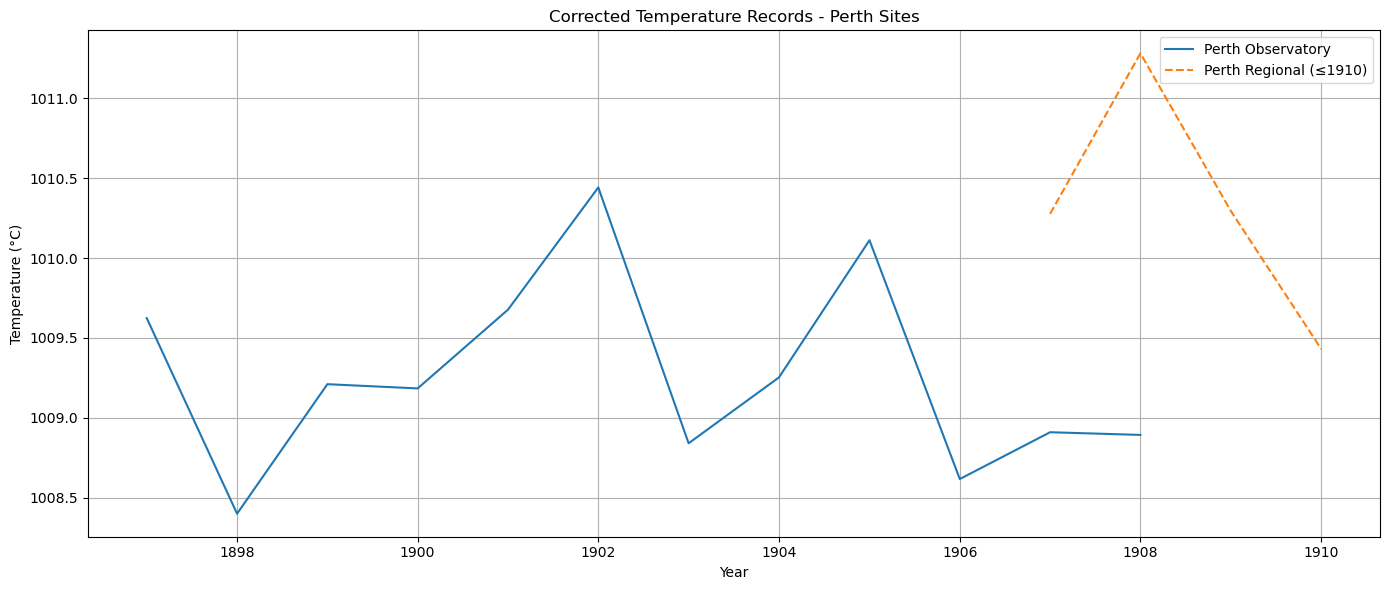

In [156]:
# Plot
plt.figure(figsize=(14, 6))
plt.plot(Perth_Observatory_Temp_Corrected['Pressure'].resample('D').mean().resample('YS').mean(), label='Perth Observatory')
plt.plot(Perth_Regional_Temp_Corrected['Reduced Temp Pressure (mb)'].resample('D').mean().resample('YS').mean(), label='Perth Regional (≤1910)', linestyle='--')

plt.title('Corrected Temperature Records - Perth Sites')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

SEF 1.0.0
ID  OXFORD RADCLIFFE
Name OXFORD RADCLIFFE (BAROMETER)
LAT 51.76
LON -1.26
Alt 66
Source Hawkins and Burt
Link
Vbl p
Stat point
Units hPa
Meta PTC=Y|PGC=N

Year Month Day Hour Minute Period Value Meta
                                        original 29.27 inHg | Tatt 25.0 F

### Firstly, all information requried

### Secondly, all information into UTC
UTC is 8 hours behind Perth, without daylight savings

1. The time (year, month, day, year, minute) needs to be in UTC, not local time. This adds a slight complication for your data, as some observations may be the day before in UTC. The averaging period column is zero for instantaneous observations.


In [254]:
Perth_Regional_Temp_Corrected/33.86

,Raw mb,Reduced Temp Pressure (mb)
Date,,
1907-01-01 09:00:00,29.914,29.805645
1907-01-01 15:00:00,29.918,29.806921
1907-01-01 21:00:00,NaN,NaN
1907-01-02 09:00:00,29.968,29.861349
1907-01-02 15:00:00,29.900,29.783573
...,...,...
1910-12-30 15:00:00,29.964,29.851936
1910-12-30 21:00:00,NaN,NaN
1910-12-31 09:00:00,30.086,29.983288


In [255]:
#Cleaning the data for export
SWR=  SWR_River_Temp_Corrected
SWR = SWR.rename(columns = {'Reduced Temp Pressure (mb)':'Value'})
SWR = SWR.rename(columns = {'Raw mb':'original'})
SWR = SWR.merge(SWR_Temp_Trans, left_index=True, right_index=True, how='outer')
SWR['temp'] = ChatJR.c_to_f(SWR['temp'])
SWR['original'] = SWR['original']/33.86
SWR = SWR.round(2)
SWR = SWR.rename(columns = {'temp':'T F'})



PG = Perth_Gardens_Temp_Corrected
PG = PG.rename(columns = {'Reduced Temp Pressure (mb)':'Value'})
PG = PG.rename(columns = {'Raw mb':'original'})
PG = PG.merge(PG_Temp_Trans, left_index=True, right_index=True, how='outer')
PG['original'] = (PG['original']/33.86).round(3)
PG['Value'] = PG['Value'].round(2)
PG = PG.dropna()
PG = PG.rename(columns = {'degF':'T F'})



PO = Perth_Observatory_Temp_Corrected 
PO = PO.rename(columns = {'Pressure':'Value'})
PO = PO.merge(PO_Temp_Trans, left_index=True, right_index=True, how='outer')
PO['Value'] = PO['Value'].astype(float)
PO = PO.round(2).dropna()
PO = PO.rename(columns = {'degF':'T F'})


PRO = Perth_Regional_Temp_Corrected 
PRO = PRO.rename(columns = {'Reduced Temp Pressure (mb)':'Value'})
PRO = PRO.rename(columns = {'Raw mb':'original'})
PRO = PRO.merge(PRO_Temp_Trans, left_index=True, right_index=True, how='outer')
PRO['original'] = (PRO['original']/33.86).round(3)
PRO['Value'] = PRO['Value'].round(2)
PRO = PRO.dropna()
PRO = PRO.rename(columns = {'degF':'T F'})


SWR['Original Time'] = SWR.index
PG['Original Time'] = PG.index
PO['Original Time'] = PO.index
PRO['Original Time'] = PRO.index

#SPLIT PG
PG_80_84 = PG.loc[:'1884']
PG_85_87 = PG.loc['1885':'13-07-1887']
PG_87_00 = PG.loc['14-07-1887':]


SWR.index = SWR.index - pd.Timedelta(hours=8)
PG_80_84.index = PG_80_84.index - pd.Timedelta(hours=8)
PG_85_87.index = PG_85_87.index - pd.Timedelta(hours=8)
PG_87_00.index = PG_87_00.index - pd.Timedelta(hours=8)
PO.index = PO.index - pd.Timedelta(hours=8)
PRO.index = PRO.index - pd.Timedelta(hours=8)


In [256]:
PO

,Value,T F,Original Time
Date,,,
1897-01-01 01:00:00,1007.98,80.0,1897-01-01 09:00:00
1897-01-02 01:00:00,1012.10,64.0,1897-01-02 09:00:00
1897-01-03 01:00:00,1010.83,75.0,1897-01-03 09:00:00
1897-01-04 01:00:00,1011.34,68.0,1897-01-04 09:00:00
1897-01-05 01:00:00,1005.78,84.0,1897-01-05 09:00:00
...,...,...,...
1908-12-30 07:00:00,1004.54,82.0,1908-12-30 15:00:00
1908-12-30 13:00:00,1006.09,69.6,1908-12-30 21:00:00
1908-12-31 01:00:00,1004.06,83.8,1908-12-31 09:00:00


# EXPORT SWAN  RIVER

In [257]:
SWR['Year'] = SWR.index.year
SWR['Day'] = SWR.index.day
SWR['Month'] = SWR.index.month
SWR['Hour'] = SWR.index.hour
SWR['Minute'] = SWR.index.minute
SWR['Period'] = 0
# Add the Meta column to SWR, one string per row
SWR['Meta'] = SWR.apply(lambda row: f"original {row['original']} inHg | Temp {row['T F']} F | Original Date {row['Original Time']}", axis=1)
SWR = SWR[['Year','Month','Day','Hour','Minute','Period','Value','Meta']].reset_index(drop =True)


# Define SEF header fields in the correct order
sef_header = [
    "SEF\t1.0.0",
    "ID\tSwan_River",
    "Name\tSwan River (Barometer)",
    "Lat\t-31.9531",          # Degrees north (negative for south)
    "Lon\t115.8719",          # Degrees east
    "Alt\t14.3",             # Elevation in meters
    "Source\tJGergis JRowe",
    "Link\t",
    "Vbl\tp",               # e.g., 'P' for pressure, 'T' for temperature
    "Stat\tpoint",           # e.g., mean, max, min
    "Units\thPa",
    "Meta\tPTC=Y | PGC=N"
]

# Join header lines as one string to write to a file or print
header_block = "\n".join(sef_header)

# Join header lines
header_block = "\n".join(sef_header)

# Open the SEF file for writin"C:\Users\jarra\Desktop\EUROPE PRINTED ITENERARY"g
with open(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Data files\Eds Pressure Datasets\SWAN_RIVER_BAROMETER_p_18300522_18751231.sef", "w", encoding="utf-8") as f:
    # Write header block
    f.write(header_block + "\n")
    
    # Write column names as line 13, tab-separated
    f.write("\t".join(SWR.columns) + "\n")
    
    # Write data rows tab-separated, no header, no index
    SWR.to_csv(f, sep="\t", header=False, index=False)
SWR

,Year,Month,Day,Hour,Minute,Period,Value,Meta
0,1830,5,22,4,0,0,1013.34,original 30.01 inHg | Temp 62.4 F | Original D...
1,1830,5,22,7,0,0,1014.69,original 30.05 inHg | Temp 62.4 F | Original D...
2,1830,5,24,1,0,0,1008.02,original 29.85 inHg | Temp 61.5 F | Original D...
3,1830,5,24,4,0,0,1011.71,original 29.97 inHg | Temp 65.5 F | Original D...
4,1830,5,24,7,0,0,1011.66,original 29.97 inHg | Temp 66.0 F | Original D...
...,...,...,...,...,...,...,...,...
25961,1875,12,29,8,0,0,1015.91,original 30.17 inHg | Temp 93.0 F | Original D...
25962,1875,12,30,2,0,0,1015.94,original 30.13 inHg | Temp 78.1 F | Original D...
25963,1875,12,30,8,0,0,1015.03,original 30.13 inHg | Temp 88.0 F | Original D...
25964,1875,12,31,2,0,0,1015.71,original 30.12 inHg | Temp 77.0 F | Original D...


# EXPORT PERTH GARDENS 80-84

In [258]:
PG_80_84['Year'] = PG_80_84.index.year
PG_80_84['Day'] = PG_80_84.index.day
PG_80_84['Month'] = PG_80_84.index.month
PG_80_84['Hour'] = PG_80_84.index.hour
PG_80_84['Minute'] = PG_80_84.index.minute
PG_80_84['Period'] = 0
# Add the Meta column to SWR, one string per row
PG_80_84['Meta'] = PG_80_84.apply(lambda row: f"original {row['original']} inHg | Tatt {row['T F']} F | Original Date {row['Original Time']}", axis=1)
PG_80_84 = PG_80_84[['Year','Month','Day','Hour','Minute','Period','Value','Meta']].reset_index(drop =True)




# Define SEF header fields in the correct order
sef_header = [
    "SEF\t1.0.0",
    "ID\tPerth_Gardens_1880_1884",
    "Name\tPerth Gardens 1880 1884 (Barometer)",
    "Lat\t-31.9531",          # Degrees north (negative for south)
    "Lon\t115.8722",          # Degrees east
    "Alt\t14.3",             # Elevation in meters
    "Source\tJGergis JRowe",
    "Link\t",
    "Vbl\tp",               # e.g., 'P' for pressure, 'T' for temperature
    "Stat\tpoint",           # e.g., mean, max, min
    "Units\thPa",
    "Meta\tPTC=Y | PGC=N"
]

# Join header lines as one string to write to a file or print
header_block = "\n".join(sef_header)

# Join header lines
header_block = "\n".join(sef_header)

# Open the SEF file for writin"C:\Users\jarra\Desktop\EUROPE PRINTED ITENERARY"g
with open(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Data files\Eds Pressure Datasets\PERTH_GARDENS_BAROMETER_p_18800101_18841231.sef", "w", encoding="utf-8") as f:
    # Write header block
    f.write(header_block + "\n")
    
    # Write column names as line 13, tab-separated
    f.write("\t".join(PG_80_84.columns) + "\n")
    
    # Write data rows tab-separated, no header, no index
    PG_80_84.to_csv(f, sep="\t", header=False, index=False)
PG_80_84

C:\Users\jarra\AppData\Local\Temp\ipykernel_28708\3315711856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PG_80_84['Year'] = PG_80_84.index.year
C:\Users\jarra\AppData\Local\Temp\ipykernel_28708\3315711856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PG_80_84['Day'] = PG_80_84.index.day
C:\Users\jarra\AppData\Local\Temp\ipykernel_28708\3315711856.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

,Year,Month,Day,Hour,Minute,Period,Value,Meta
0,1880,1,1,1,0,0,1009.78,original 29.97 inHg | Tatt 84.0 F | Original D...
1,1880,1,1,4,0,0,1007.66,original 29.924 inHg | Tatt 90.0 F | Original ...
2,1880,1,2,1,0,0,1008.50,original 29.932 inHg | Tatt 84.0 F | Original ...
3,1880,1,2,4,0,0,1003.28,original 29.794 inHg | Tatt 90.0 F | Original ...
4,1880,1,3,1,0,0,1005.64,original 29.85 inHg | Tatt 85.0 F | Original D...
...,...,...,...,...,...,...,...,...
3586,1884,12,29,4,0,0,1012.29,original 30.01 inHg | Tatt 72.0 F | Original D...
3587,1884,12,29,23,0,0,1011.32,original 29.97 inHg | Tatt 68.0 F | Original D...
3588,1884,12,30,4,0,0,1011.34,original 29.982 inHg | Tatt 72.0 F | Original ...
3589,1884,12,30,23,0,0,1009.96,original 29.924 inHg | Tatt 66.0 F | Original ...


In [259]:
PO[PO['Value'] == np.nan]

,Value,T F,Original Time
Date,,,


# EXPORT PERTH GARDENS 85-87

In [260]:
PG_85_87['Year'] = PG_85_87.index.year
PG_85_87['Day'] = PG_85_87.index.day
PG_85_87['Month'] = PG_85_87.index.month
PG_85_87['Hour'] = PG_85_87.index.hour
PG_85_87['Minute'] = PG_85_87.index.minute
PG_85_87['Period'] = 0
# Add the Meta column to SWR, one string per row
PG_85_87['Meta'] = PG_85_87.apply(lambda row: f"original {row['original']} inHg | Tatt {row['T F']} F | Original Date {row['Original Time']}", axis=1)
PG_85_87 = PG_85_87[['Year','Month','Day','Hour','Minute','Period','Value','Meta']].reset_index(drop =True)




# Define SEF header fields in the correct order
sef_header = [
    "SEF\t1.0.0",
    "ID\tPerth_Gardens_1885_1887",
    "Name\tPerth Gardens 1885 1887 (Barometer)",
    "Lat\t-31.9531",          # Degrees north (negative for south)
    "Lon\t115.8722",          # Degrees east
    "Alt\t18",             # Elevation in meters
    "Source\tJGergis JRowe",
    "Link\t",
    "Vbl\tp",               # e.g., 'P' for pressure, 'T' for temperature
    "Stat\tpoint",           # e.g., mean, max, min
    "Units\thPa",
    "Meta\tPTC=Y | PGC=N"
]

# Join header lines as one string to write to a file or print
header_block = "\n".join(sef_header)

# Join header lines
header_block = "\n".join(sef_header)

# Open the SEF file for writin"C:\Users\jarra\Desktop\EUROPE PRINTED ITENERARY"g
with open(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Data files\Eds Pressure Datasets\PERTH_GARDENS_BAROMETER_p_18850101_18870713.sef", "w", encoding="utf-8") as f:
    # Write header block
    f.write(header_block + "\n")
    
    # Write column names as line 13, tab-separated
    f.write("\t".join(PG_85_87.columns) + "\n")
    
    # Write data rows tab-separated, no header, no index
    PG_85_87.to_csv(f, sep="\t", header=False, index=False)

C:\Users\jarra\AppData\Local\Temp\ipykernel_28708\3309240548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PG_85_87['Year'] = PG_85_87.index.year
C:\Users\jarra\AppData\Local\Temp\ipykernel_28708\3309240548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PG_85_87['Day'] = PG_85_87.index.day
C:\Users\jarra\AppData\Local\Temp\ipykernel_28708\3309240548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

# EXPORT PERTH GARDENS 87-00

In [261]:
PG_87_00['Year'] = PG_87_00.index.year
PG_87_00['Day'] = PG_87_00.index.day
PG_87_00['Month'] = PG_87_00.index.month
PG_87_00['Hour'] = PG_87_00.index.hour
PG_87_00['Minute'] = PG_87_00.index.minute
PG_87_00['Period'] = 0
# Add the Meta column to SWR, one string per row
PG_87_00['Meta'] = PG_87_00.apply(lambda row: f"original {row['original']} inHg | Tatt {row['T F']} F | Original Date {row['Original Time']}", axis=1)
PG_87_00 = PG_87_00[['Year','Month','Day','Hour','Minute','Period','Value','Meta']].reset_index(drop =True)




# Define SEF header fields in the correct order
sef_header = [
    "SEF\t1.0.0",
    "ID\tPerth_Gardens_1887_1900",
    "Name\tPerth Gardens 1887 1900 (Barometer)",
    "Lat\t-31.9558",          # Degrees north (negative for south)
    "Lon\t115.8603",          # Degrees east
    "Alt\t14.3",             # Elevation in meters
    "Source\tJGergis JRowe",
    "Link\t",
    "Vbl\tp",               # e.g., 'P' for pressure, 'T' for temperature
    "Stat\tpoint",           # e.g., mean, max, min
    "Units\thPa",
    "Meta\tPTC=Y | PGC=N"
]

# Join header lines as one string to write to a file or print
header_block = "\n".join(sef_header)

# Join header lines
header_block = "\n".join(sef_header)

# Open the SEF file for writin"C:\Users\jarra\Desktop\EUROPE PRINTED ITENERARY"g
with open(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Data files\Eds Pressure Datasets\PERTH_GARDENS_BAROMETER_p_18870714_19001231.sef", "w", encoding="utf-8") as f:
    # Write header block
    f.write(header_block + "\n")
    
    # Write column names as line 13, tab-separated
    f.write("\t".join(PG_87_00.columns) + "\n")
    
    # Write data rows tab-separated, no header, no index
    PG_87_00.to_csv(f, sep="\t", header=False, index=False)

PG_87_00

C:\Users\jarra\AppData\Local\Temp\ipykernel_28708\3248801023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PG_87_00['Year'] = PG_87_00.index.year
C:\Users\jarra\AppData\Local\Temp\ipykernel_28708\3248801023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PG_87_00['Day'] = PG_87_00.index.day
C:\Users\jarra\AppData\Local\Temp\ipykernel_28708\3248801023.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

,Year,Month,Day,Hour,Minute,Period,Value,Meta
0,1887,7,14,1,0,0,1011.99,original 29.964 inHg | Tatt 59.0 F | Original ...
1,1887,7,14,7,0,0,1009.97,original 29.91 inHg | Tatt 61.0 F | Original D...
2,1887,7,15,1,0,0,1014.61,original 30.036 inHg | Tatt 57.0 F | Original ...
3,1887,7,15,7,0,0,1018.10,original 30.148 inHg | Tatt 60.0 F | Original ...
4,1887,7,16,1,0,0,1022.79,original 30.284 inHg | Tatt 59.0 F | Original ...
...,...,...,...,...,...,...,...,...
9746,1900,12,28,4,0,0,1008.82,original 29.93 inHg | Tatt 80.0 F | Original D...
9747,1900,12,29,1,0,0,1010.83,original 29.964 inHg | Tatt 71.0 F | Original ...
9748,1900,12,30,1,0,0,1018.01,original 30.174 inHg | Tatt 70.0 F | Original ...
9749,1900,12,31,1,0,0,1019.90,original 30.224 inHg | Tatt 68.0 F | Original ...


In [262]:
PG_87_00

,Year,Month,Day,Hour,Minute,Period,Value,Meta
0,1887,7,14,1,0,0,1011.99,original 29.964 inHg | Tatt 59.0 F | Original ...
1,1887,7,14,7,0,0,1009.97,original 29.91 inHg | Tatt 61.0 F | Original D...
2,1887,7,15,1,0,0,1014.61,original 30.036 inHg | Tatt 57.0 F | Original ...
3,1887,7,15,7,0,0,1018.10,original 30.148 inHg | Tatt 60.0 F | Original ...
4,1887,7,16,1,0,0,1022.79,original 30.284 inHg | Tatt 59.0 F | Original ...
...,...,...,...,...,...,...,...,...
9746,1900,12,28,4,0,0,1008.82,original 29.93 inHg | Tatt 80.0 F | Original D...
9747,1900,12,29,1,0,0,1010.83,original 29.964 inHg | Tatt 71.0 F | Original ...
9748,1900,12,30,1,0,0,1018.01,original 30.174 inHg | Tatt 70.0 F | Original ...
9749,1900,12,31,1,0,0,1019.90,original 30.224 inHg | Tatt 68.0 F | Original ...


# EXPORT PERTH OBSERVATORY

In [263]:
PO['Year'] = PO.index.year
PO['Day'] = PO.index.day
PO['Month'] = PO.index.month
PO['Hour'] = PO.index.hour
PO['Minute'] = PO.index.minute
PO['Period'] = 0
# Add the Meta column to SWR, one string per row
PO['Meta'] = PO.apply(lambda row: f"Tdrybulb {row['T F']} F | Original Date {row['Original Time']}", axis=1)
PO = PO[['Year','Month','Day','Hour','Minute','Period','Value','Meta']].reset_index(drop =True)




# Define SEF header fields in the correct order
sef_header = [
    "SEF\t1.0.0",
    "ID\tPerth_Observatory",
    "Name\tPerth Observatory (Barometer)",
    "Lat\t-31.9528",          # Degrees north (negative for south)
    "Lon\t115.8401",          # Degrees east
    "Alt\t60",             # Elevation in meters
    "Source\tJGergis JRowe",
    "Link\t",
    "Vbl\tp",               # e.g., 'P' for pressure, 'T' for temperature
    "Stat\tpoint",           # e.g., mean, max, min
    "Units\thPa",
    "Meta\tPTC=Y | PGC=N"
]

# Join header lines as one string to write to a file or print
header_block = "\n".join(sef_header)

# Join header lines
header_block = "\n".join(sef_header)

# Open the SEF file for writin"C:\Users\jarra\Desktop\EUROPE PRINTED ITENERARY"g
with open(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Data files\Eds Pressure Datasets\PERTH_OBSERVATORY_BAROMETER_p_19870101_19081231.sef", "w", encoding="utf-8") as f:
    # Write header block
    f.write(header_block + "\n")
    
    # Write column names as line 13, tab-separated
    f.write("\t".join(PO.columns) + "\n")
    
    # Write data rows tab-separated, no header, no index
    PO.to_csv(f, sep="\t", header=False, index=False)
PO

,Year,Month,Day,Hour,Minute,Period,Value,Meta
0,1897,1,1,1,0,0,1007.98,Tdrybulb 80.0 F | Original Date 1897-01-01 09:...
1,1897,1,2,1,0,0,1012.10,Tdrybulb 64.0 F | Original Date 1897-01-02 09:...
2,1897,1,3,1,0,0,1010.83,Tdrybulb 75.0 F | Original Date 1897-01-03 09:...
3,1897,1,4,1,0,0,1011.34,Tdrybulb 68.0 F | Original Date 1897-01-04 09:...
4,1897,1,5,1,0,0,1005.78,Tdrybulb 84.0 F | Original Date 1897-01-05 09:...
...,...,...,...,...,...,...,...,...
9114,1908,12,30,7,0,0,1004.54,Tdrybulb 82.0 F | Original Date 1908-12-30 15:...
9115,1908,12,30,13,0,0,1006.09,Tdrybulb 69.6 F | Original Date 1908-12-30 21:...
9116,1908,12,31,1,0,0,1004.06,Tdrybulb 83.8 F | Original Date 1908-12-31 09:...
9117,1908,12,31,7,0,0,1001.72,Tdrybulb 87.3 F | Original Date 1908-12-31 15:...


# EXPORT PERTH REGIONAL OFFICE

In [264]:
PRO['Year'] = PRO.index.year
PRO['Day'] = PRO.index.day
PRO['Month'] = PRO.index.month
PRO['Hour'] = PRO.index.hour
PRO['Minute'] = PRO.index.minute
PRO['Period'] = 0
# Add the Meta column to SWR, one string per row
PRO['Meta'] =PRO.apply(lambda row: f"original {row['original']} inHg | Tatt {row['T F']} F | Original Date {row['Original Time']}", axis=1)
PRO = PRO[['Year','Month','Day','Hour','Minute','Period','Value','Meta']].reset_index(drop =True)




# Define SEF header fields in the correct order
sef_header = [
    "SEF\t1.0.0",
    "ID\tPerth_Regional_Office",
    "Name\tPerth Regional Office (Barometer)",
    "Lat\t-31.9533",          # Degrees north (negative for south)
    "Lon\t115.8442",          # Degrees east
    "Alt\t60",             # Elevation in meters
    "Source\tJGergis JRowe",
    "Link\t",
    "Vbl\tp",               # e.g., 'P' for pressure, 'T' for temperature
    "Stat\tpoint",           # e.g., mean, max, min
    "Units\thPa",
    "Meta\tPTC=Y | PGC=N"
]

# Join header lines as one string to write to a file or print
header_block = "\n".join(sef_header)

# Join header lines
header_block = "\n".join(sef_header)

# Open the SEF file for writin"C:\Users\jarra\Desktop\EUROPE PRINTED ITENERARY"g
with open(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Data files\Eds Pressure Datasets\PERTH_REGIONAL_OFFICE_BAROMETER_p_19070101_19101231.sef", "w", encoding="utf-8") as f:
    # Write header block
    f.write(header_block + "\n")
    
    # Write column names as line 13, tab-separated
    f.write("\t".join(PRO.columns) + "\n")
    
    # Write data rows tab-separated, no header, no index
    PRO.to_csv(f, sep="\t", header=False, index=False)
PRO

,Year,Month,Day,Hour,Minute,Period,Value,Meta
0,1907,1,1,1,0,0,1009.22,original 29.914 inHg | Tatt 72.0 F | Original ...
1,1907,1,1,7,0,0,1009.26,original 29.918 inHg | Tatt 73.0 F | Original ...
2,1907,1,2,1,0,0,1011.11,original 29.968 inHg | Tatt 71.3 F | Original ...
3,1907,1,2,7,0,0,1008.47,original 29.9 inHg | Tatt 75.0 F | Original Da...
4,1907,1,3,1,0,0,1005.29,original 29.8 inHg | Tatt 72.9 F | Original Da...
...,...,...,...,...,...,...,...,...
2915,1910,12,29,7,0,0,1011.44,original 29.972 inHg | Tatt 69.1 F | Original ...
2916,1910,12,30,1,0,0,1012.39,original 29.994 inHg | Tatt 66.9 F | Original ...
2917,1910,12,30,7,0,0,1010.79,original 29.964 inHg | Tatt 73.3 F | Original ...
2918,1910,12,31,1,0,0,1015.23,original 30.086 inHg | Tatt 69.7 F | Original ...


2. Everything is tab separated (tsv).
4. One line per individual observation with a known time. The metadata column is optional (especially for the initial sharing with us stage). If extra information in raw units is possible to add then the GLAMOD team would be grateful (like attached example) – different elements are separated by pipes (|) and could include e.g. local time information too.
5. Overlapping stations are fine – if there are 2 or more nearby stations then it is best to have both files as all observations are assimilated with an uncertainty. Having multiple independent observations helps constrain the reanalysis better. E.g. for Oxford we have some data taken with a barometer and a barograph at the same place and same time and we will assimilate both.
6. The global metadata header line can include indicators like PTC=Y | PGC=N (pressure temperature corrected yes, pressure gravity correction made no).
7. Every observation has a rolling interactive bias correction applied inside the reanalysis. This is to account for station height uncertainty, gravity correction, mismatches between model and observed climatologies etc etc. This doesn’t matter for producing the SEF file but if e.g. the altitude is not known perfectly, then this will get accounted for.

In [265]:
PRO

,Year,Month,Day,Hour,Minute,Period,Value,Meta
0,1907,1,1,1,0,0,1009.22,original 29.914 inHg | Tatt 72.0 F | Original ...
1,1907,1,1,7,0,0,1009.26,original 29.918 inHg | Tatt 73.0 F | Original ...
2,1907,1,2,1,0,0,1011.11,original 29.968 inHg | Tatt 71.3 F | Original ...
3,1907,1,2,7,0,0,1008.47,original 29.9 inHg | Tatt 75.0 F | Original Da...
4,1907,1,3,1,0,0,1005.29,original 29.8 inHg | Tatt 72.9 F | Original Da...
...,...,...,...,...,...,...,...,...
2915,1910,12,29,7,0,0,1011.44,original 29.972 inHg | Tatt 69.1 F | Original ...
2916,1910,12,30,1,0,0,1012.39,original 29.994 inHg | Tatt 66.9 F | Original ...
2917,1910,12,30,7,0,0,1010.79,original 29.964 inHg | Tatt 73.3 F | Original ...
2918,1910,12,31,1,0,0,1015.23,original 30.086 inHg | Tatt 69.7 F | Original ...


### completed in section 4
3. We need one SEF file per station with unique name/lat/lon/altitude characteristics. The best observations are those corrected to 32F at station height (variable p). Homogenised data for one location is also fine. We can also use data reduced to sea level (variable mslp) but these have a larger uncertainty assumed in the reanalysis.


In [179]:
PG_1884 = PG.loc

In [180]:
PG['Original Time'] = PG.index
PG.index = PG.index - pd.Timedelta(hours=8)

PG['Year'] = PG.index.year
PG['Day'] = PG.index.day
PG['Month'] = PG.index.month
PG['Hour'] = PG.index.hour
PG['Minute'] = PG.index.minute
PG['Period'] = 0
# Add the Meta column to SWR, one string per row
PG['Meta'] = PG.apply(lambda row: f"original {row['original']} inHg | Temp {row['T F']} F | Original Date {row['Original Time']}", axis=1)
PG = PG[['Year','Month','Day','Hour','Minute','Period','Value','Meta']].reset_index(drop =True)


# Define SEF header fields in the correct order
sef_header = [
    "SEF:\t1.0.0",
    "ID:\tPerth_Gardens",
    "Name:\tPerth Gardens (Barometer)",
    "Lat:\t-31.9531",          # Degrees north (negative for south)
    "Lon:\t115.872",          # Degrees east
    "Alt:\t14.3",             # Elevation in meters
    "Source:\tJGergis",
    "Link:\t",
    "Vbl:\tp",               # e.g., 'P' for pressure, 'T' for temperature
    "Stat:\tpoint",           # e.g., mean, max, min
    "Units:\thPa",
    "Meta:\tPTC=Y | PGC=N"
]

# Join header lines as one string to write to a file or print
header_block = "\n".join(sef_header)

# Join header lines
header_block = "\n".join(sef_header)

# Open the SEF file for writin"C:\Users\jarra\Desktop\EUROPE PRINTED ITENERARY"g
with open(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Eds Pressure Datasets\SWAN_RIVER_BAROMETER_p_18300522_18751231.sef", "w", encoding="utf-8") as f:
    # Write header block
    f.write(header_block + "\n")
    
    # Write column names as line 13, tab-separated
    f.write("\t".join(SWR.columns) + "\n")
    
    # Write data rows tab-separated, no header, no index
    SWR.to_csv(f, sep="\t", header=False, index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jarra\\Dropbox\\Perth pressure record 1830-2024\\Eds Pressure Datasets\\SWAN_RIVER_BAROMETER_p_18300522_18751231.sef'

In [ ]:
# PG MOnthly

In [ ]:
PGm_Pres_Trans['Correct_temp_mslp'] = PGm_Pres_Trans['inHg']*33.86
P = PGm_Pres_Trans[['Correct_temp_mslp']]
# 1880-1884
P_80_84 = P.loc[:'1884-12-31']
# 1885-1887-06
P_85_87 = P.loc['1885-01-01':'1887-06-01']
# 1885-1900B
P_87_00 = P.loc['1887-07-01':]

#TO_Sp


def TO_SP(MSLP, Temp, elevation):
    '''
    Calculate Mean Sea Level Pressure (MSLP) using the Hypsometric equation.
    
    Args:
    - Pres: Pressure data (already corrected for temperature).
    - Temp: Temperature data in degrees Celsius.
    - elevation: Elevation in meters.
    
    Returns:
    - Updated pressure data with MSLP.
    '''
    
    A = elevation * 9.81 
    B = 287 * (Temp['degC'] + 273.15)
    C = A/B
    C = pd.to_numeric(C, errors='coerce')
    D = np.exp(C)

    SP = MSLP/D
    return SP

TO_SP(MSLP, Temp, elevation)

#We need temp for to_SP so cannot do

In [ ]:
P_80_84